In [1]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [2]:
def create_folder(*subfolders):
    # create the base folder
    base_folder = os.path.expanduser('~')
    folder_list = [base_folder] + list(subfolders)
    folder_path = os.path.join(*folder_list)

    # create the folder
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    return folder_path

In [3]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
from pathlib import Path
import pandas as pd

# do not change directory but still go to the folder with the models
folder = Path().cwd() / "cs_mods" / "August2023"
model_list = []
for file in folder.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem # remove .xml
    model_list.append(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-03


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [4]:
model_list

[<Model Human-GEM_28062023 at 0x200b269d720>,
 <Model mod_RPE_PRcone_Liang at 0x200bb37c1f0>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x20087f8c850>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x2009f188580>,
 <Model mod_RPE_PRcone_Lukowski at 0x200a3e88820>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x201068402e0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x2010d92ed40>,
 <Model mod_RPE_PRcontrol at 0x201127b2aa0>,
 <Model mod_RPE_PRrod_Liang at 0x200ff4a3730>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x201798fa440>,
 <Model mod_RPE_PRrod_Liang_singlePRE at 0x2017df43d90>,
 <Model mod_RPE_PRrod_Lukowski at 0x20182c37910>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x2018b646d10>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x20190be3790>]

In [5]:
# select only models containing Lukowski in their name 
model_list = [model for model in model_list if 'Lukowski' in model.id \
                        or 'Human-GEM' in model.id\
                        or 'control' in model.id]
model_list

[<Model Human-GEM_28062023 at 0x200b269d720>,
 <Model mod_RPE_PRcone_Lukowski at 0x200a3e88820>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x201068402e0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x2010d92ed40>,
 <Model mod_RPE_PRcontrol at 0x201127b2aa0>,
 <Model mod_RPE_PRrod_Lukowski at 0x20182c37910>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x2018b646d10>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x20190be3790>]

In [6]:
# modify models

# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)
for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
        m.reactions.get_by_id('MAR03964_PR').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
        m.reactions.get_by_id('MAR03964_RPE').bounds = (-1000,1000)
        m.objective.direction = 'max'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
        m.reactions.get_by_id('MAR03964').bounds = (-1000,1000)
        m.objective.direction = 'max'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id and 'Human' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]
Human1_models = [m for m in model_list if 'Human' in m.id]

# allow all metabolites out (open efflux) and open influx for water
for m in model_list:
    for r in [r for r in m.reactions if len(r.products) == 0]:
        r.bounds = (0,0)
    for r in [r for r in m.reactions if len(r.products) == 0  if '_eRPE_PR' not in r.id]:  # open efflux for exchange reactions (except for with the RPE-PR[e] interface)
        r.bounds=(0,1000)
    for r in [r for r in m.reactions if 'MAR09047' in r.id and '_eRPE_PR' not in r.id]: # MAR09047: water
        r.bounds=(-1000,1000) 

In [7]:
model_list[0].reactions.get_by_id('MAR03964')

Reaction identifier,MAR03964
Name,ATP phosphohydrolase
Memory address,0x200b7d85750
Stoichiometry,MAM01371c + MAM02040c <=> MAM01285c + MAM02039c + MAM02751c ATP + H2O <=> ADP + H+ + Pi
GPR,
Lower bound,-1000
Upper bound,1000


In [8]:
print('list of H2O exchange reactions in model at position 1 in model_list:')
[r for r in model_list[1].reactions if 'MAR09047' in r.id]

list of H2O exchange reactions in model at position 1 in model_list:


[<Reaction MAR09047_RPE at 0x201015d4b50>,
 <Reaction MAR09047_eRPE_PR at 0x20102638850>,
 <Reaction MAR09047_PR at 0x20105416080>]

In [9]:
print('H2O exchange bounds with PR: ' + str(model_list[1].reactions.get_by_id('MAR09047_PR').bounds))
print('H2O exchange bounds with RPE: ' + str(model_list[1].reactions.get_by_id('MAR09047_RPE').bounds))
print('H2O exchange bounds with RPE-PR interface: ' + str(model_list[1].reactions.get_by_id('MAR09047_eRPE_PR').bounds))

H2O exchange bounds with PR: (-1000, 1000)
H2O exchange bounds with RPE: (-1000, 1000)
H2O exchange bounds with RPE-PR interface: (0, 0)


In [10]:
single_models

[<Model mod_RPE_PRcone_Lukowski_singlePR at 0x201068402e0>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x2010d92ed40>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x2018b646d10>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x20190be3790>]

In [11]:
Human1_models

[<Model Human-GEM_28062023 at 0x200b269d720>]

In [12]:
Human1_models[0].reactions.get_by_id('MAR03964')

Reaction identifier,MAR03964
Name,ATP phosphohydrolase
Memory address,0x200b7d85750
Stoichiometry,MAM01371c + MAM02040c <=> MAM01285c + MAM02039c + MAM02751c ATP + H2O <=> ADP + H+ + Pi
GPR,
Lower bound,-1000
Upper bound,1000


In [13]:
# load blood exchange bounds
import pandas as pd
df = pd.read_excel(Path().cwd() / 'rxn_bounds/blood_selection.xlsx') # with col names 'id' 'lb' 'ub'
blood_ratio = {df['id_single'][i]:df['ratio [glucose]/[x]'] [i] for i in range(len(df['id']))}

# dictionary comprehension to replace values with 50% and 10% values in dict
blood_ratio200 = {k:2*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio100 = {k:1*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio50 = {k: 0.5*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio25 = {k: 0.25*blood_ratio[k] for k in blood_ratio.keys()}
blood_ratio0 = {k: 0.00*blood_ratio[k] for k in blood_ratio.keys()}

br_list = [blood_ratio200, blood_ratio100, blood_ratio50, blood_ratio25, blood_ratio0]

In [14]:
def open_blood_exchange(mod,br, glucose_level, RPE_PR = 'RPE'):  
    suffix = '_PR' if RPE_PR == 'PR' \
        else '_RPE' if RPE_PR == 'RPE' \
        else '' if RPE_PR == '' \
        else print('RPE_PR must be PR, RPE or empty string')

    br_updated = br.copy()
    br_updated.update((x, y * glucose_level) for x, y in br_updated.items())
    for key in br:
        if key in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key).bounds = (br_updated[key],1000)# allow influx for RPE exchange reactions (blood exchange)
        elif key + suffix in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + suffix).bounds = (br_updated[key],1000)
        elif key + '_RPE' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_RPE').bounds = (br_updated[key],1000)
        elif key + '_PR' in [r.id for r in mod.reactions]:
            mod.reactions.get_by_id(key + '_PR').bounds = (br_updated[key],1000)
        else: 
            print(key + ' not in model')
    return mod


In [15]:
[[r.id, r.reaction] for r in model_list[1].reactions if 'MAR04896' in r.id]

[['MAR04896_RPE', 'MAM02630c_RPE <=> MAM02630e_RPE'],
 ['MAR04896_RPE_PR', 'MAM02630c_RPE <=> MAM02630e_RPE_PR'],
 ['MAR04896_PR', 'MAM02630c_PR <=> MAM02630e_PR'],
 ['MAR04896_PR_RPE', 'MAM02630c_PR <=> MAM02630e_RPE_PR']]

In [16]:
# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

##############################################################
#######    total exchange (for single models)        #########
##############################################################

# PARAFOVEAL
single_ex_bounds_dark = {'MAR09048':(-4.04,-4.04),\
                      'MAR09034':(-4.81,-4.81),\
                        'MAR09135':(8.34,8.34)}

single_ex_bounds_light = {'MAR09048':(-2.76,-2.76),\
                       'MAR09034':(-2.04,-2.04),\
                        'MAR09135':(4.21,4.21)}

# FOVEAL
single_ex_bounds_dark_foveal = {'MAR09048':(-2.72,-2.72),\
                      'MAR09034':(-2.89,-2.89),\
                        'MAR09135':(5.00,5.00)}

single_ex_bounds_light_foveal = {'MAR09048':(-2.34,-2.34),\
                       'MAR09034':(-1.51,-1.51),\
                        'MAR09135':(3.11,3.11)}



##############################################################
##############     CC exchange  (CC --> RPE)  ################
####  inner retina exchange  (retina vasculature --> PR)  ####
##############################################################

# PARAFOVEAL
ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
                     'MAR04896_PR_RPE':(-3.18,-3.18),\
                      'MAR09034_RPE':(-4.14,-4.14),\
                      'MAR09135_RPE':(7.18,7.18),\
                      'MAR09048_PR':(-0.56,-0.56),\
                      'MAR09034_PR':(-0.67,-0.67),\
                      'MAR09135_PR':(1.16,1.16)}          

ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR04896_PR_RPE':(-2.19,-2.19),\
                      'MAR09034_RPE':(-1.84,-1.84),\
                      'MAR09135_RPE':(3.79,3.79),\
                      'MAR09048_PR':(-0.27,-0.27),\
                      'MAR09034_PR':(-0.20,-0.20),\
                      'MAR09135_PR':(0.41,0.41)}

# FOVEAL
ex_bounds_dark_foveal = {'MAR09048_RPE':(-2.72,-2.72),\
                     'MAR04896_PR_RPE':(-2.42,-2.42),\
                      'MAR09034_RPE':(-2.89,-2.89),\
                      'MAR09135_RPE':(5,5)}          

ex_bounds_light_foveal = {'MAR09048_RPE':(-2.34,-2.34),\
                      'MAR04896_PR_RPE':(-2.04,-2.04),\
                      'MAR09034_RPE':(-1.51,-1.51),\
                      'MAR09135_RPE':(3.11,3.11)}
	 

##############################################################
##############     for combined models      ##################
##############################################################

results_dict_dark = {}
results_dict_light = {}
results_dict_dark_foveal = {}
results_dict_light_foveal = {}

for model in combined_models:
    with model as m:
        for br in br_list:
            m = open_blood_exchange(m,br, -4.14, 'RPE')
            m = open_blood_exchange(m,br,  -0.67, 'PR')
            for ex in ex_bounds_dark.keys(): 
                m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
            m.optimize()
            results_dict_dark[str(m.id) + str(list(br.values())[0])]  = m.objective.value

            m = open_blood_exchange(m,br, -1.84, 'RPE')
            m = open_blood_exchange(m,br,  -.20, 'PR')
            for ex in ex_bounds_light.keys(): 
                m.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds
            m.optimize()
            results_dict_light[str(m.id) + str(list(br.values())[0])] = m.objective.value

            m = open_blood_exchange(m,br, -2.45, 'RPE')
            m = open_blood_exchange(m,br,  -.43, 'PR')
            for ex in ex_bounds_dark_foveal.keys(): 
                m.reactions.get_by_id(ex).bounds = ex_bounds_dark_foveal[ex]
            m.optimize()
            results_dict_dark_foveal[str(m.id) + str(list(br.values())[0])] = m.objective.value

            m = open_blood_exchange(m,br, -1.34, 'RPE')
            m = open_blood_exchange(m,br,  -.17, 'PR')
            for ex in ex_bounds_light_foveal.keys(): 
                m.reactions.get_by_id(ex).bounds = ex_bounds_light_foveal[ex]
            m.optimize()
            results_dict_light_foveal[str(m.id) + str(list(br.values())[0])] = m.objective.value


df1 = pd.DataFrame(results_dict_light, index = ['light_parafoveal']).T
df2 = pd.DataFrame(results_dict_dark, index = ['dark_parafoveal']).T
df3 = pd.DataFrame(results_dict_light_foveal, index = ['light_foveal']).T
df4 = pd.DataFrame(results_dict_dark_foveal, index = ['dark_foveal']).T

results1 = pd.concat([df1,df2,df3,df4], axis = 1)

print('COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2)')
results1

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

COMBINED MODELS: max ATP hydrolysis (pmol/s/mm^2)


c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,light_parafoveal,dark_parafoveal,light_foveal,dark_foveal
mod_RPE_PRcone_Lukowski2.0,17.927194,30.611575,16.761013,22.948627
mod_RPE_PRcone_Lukowski1.0,17.585718,30.043288,14.3799,21.710117
mod_RPE_PRcone_Lukowski0.5,8.248779,29.759144,None,21.056309
mod_RPE_PRcone_Lukowski0.25,None,29.617072,None,20.647869
mod_RPE_PRcone_Lukowski0.0,None,27.900000,None,None
mod_RPE_PRcontrol2.0,18.415882,31.861471,17.133864,23.805039
mod_RPE_PRcontrol1.0,17.808396,30.667099,16.166955,22.093088
mod_RPE_PRcontrol0.5,16.935432,30.069913,9.26127,21.237112
mod_RPE_PRcontrol0.25,9.699103,29.771320,None,20.7288
mod_RPE_PRcontrol0.0,None,28.500000,None,11.2375


In [17]:
from src.get_info import make_rxn_df    
df = make_rxn_df(combined_models[1])
df.to_clipboard()

In [18]:
results_dict_dark_single = {}
results_dict_light_single = {}
results_dict_dark_foveal_single = {}
results_dict_light_foveal_single = {}


for model in single_models + Human1_models:
    with model as m:
        for br in br_list:
            m = open_blood_exchange(m,br, -4.14-0.67, '')
            reactions_list = [r.id for r in m.reactions]
            for ex in single_ex_bounds_dark.keys(): 
                if (ex + '_RPE') in reactions_list:
                    m.reactions.get_by_id(ex + '_RPE').bounds = single_ex_bounds_dark[ex] # set exchange bounds
                elif (ex + '_PR') in reactions_list:
                    m.reactions.get_by_id(ex + '_PR').bounds = single_ex_bounds_dark[ex] # set exchange bounds
                elif (ex) in reactions_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_dark[ex]
                else:
                    print('exchange reaction not found')
            m.optimize()
            results_dict_dark_single[m.id+ str(list(br.values())[0])] = m.objective.value

            m = open_blood_exchange(m,br, -1.84-.20, '')
            for ex in single_ex_bounds_light.keys(): 
                if (ex + '_RPE') in reactions_list:
                    m.reactions.get_by_id(ex + '_RPE').bounds = single_ex_bounds_light[ex]
                elif (ex + '_PR') in reactions_list:
                    m.reactions.get_by_id(ex + '_PR').bounds = single_ex_bounds_light[ex]
                elif (ex) in reactions_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_light[ex]
                else:   
                    print('exchange reaction not found')
            m.optimize()
            results_dict_light_single[m.id+ str(list(br.values())[0])] = m.objective.value

            m = open_blood_exchange(m,br, -2.45-.43, '')
            for ex in single_ex_bounds_dark_foveal.keys(): 
                if (ex + '_RPE') in reactions_list:
                    m.reactions.get_by_id(ex + '_RPE').bounds = single_ex_bounds_dark_foveal[ex]
                elif (ex + '_PR') in reactions_list:
                    m.reactions.get_by_id(ex + '_PR').bounds = single_ex_bounds_dark_foveal[ex]
                elif (ex) in reactions_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_dark_foveal[ex]
                else:
                    print('exchange reaction not found')
            m.optimize()
            results_dict_dark_foveal_single[m.id+ str(list(br.values())[0])] = m.objective.value

            m = open_blood_exchange(m,br, -1.34-.17, '')
            for ex in single_ex_bounds_light_foveal.keys(): 
                if (ex + '_RPE') in reactions_list:
                    m.reactions.get_by_id(ex + '_RPE').bounds = single_ex_bounds_light_foveal[ex]
                elif (ex + '_PR') in reactions_list:
                    m.reactions.get_by_id(ex + '_PR').bounds = single_ex_bounds_light_foveal[ex]
                elif (ex) in reactions_list:
                    m.reactions.get_by_id(ex).bounds = single_ex_bounds_light_foveal[ex]
                else:
                    print('exchange reaction not found')
            m.optimize()
            results_dict_light_foveal_single[m.id+ str(list(br.values())[0])] = m.objective.value


df1 = pd.DataFrame(results_dict_light_single, index = ['light_parafoveal']).T
df2 = pd.DataFrame(results_dict_dark_single, index = ['dark_parafoveal']).T
df3 = pd.DataFrame(results_dict_light_foveal_single, index = ['light_foveal']).T
df4 = pd.DataFrame(results_dict_dark_foveal_single, index = ['dark_foveal']).T
results2 = pd.concat([df1,df2,df3,df4], axis = 1)

print('SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2)')
results2

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

SINGLE MODELS: max ATP hydrolysis (pmol/s/mm^2)


c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


,light_parafoveal,dark_parafoveal,light_foveal,dark_foveal
mod_RPE_PRcone_Lukowski_singlePR2.0,15.684346,29.724091,12.696918,19.005760
mod_RPE_PRcone_Lukowski_singlePR1.0,12.262931,28.082527,8.319645,17.980380
mod_RPE_PRcone_Lukowski_singlePR0.5,None,27.226263,None,17.467690
mod_RPE_PRcone_Lukowski_singlePR0.25,None,26.798132,None,17.209917
mod_RPE_PRcone_Lukowski_singlePR0.0,None,25.020000,None,14.390000
mod_RPE_PRcone_Lukowski_singleRPE2.0,17.061676,29.642356,13.170661,19.170977
mod_RPE_PRcone_Lukowski_singleRPE1.0,7.583642,29.238321,4.949436,18.890178
mod_RPE_PRcone_Lukowski_singleRPE0.5,None,28.840982,None,18.650089
mod_RPE_PRcone_Lukowski_singleRPE0.25,None,28.640491,None,18.530045
mod_RPE_PRcone_Lukowski_singleRPE0.0,None,26.940000,None,15.560000


In [19]:
#combine results1 and results2
results = pd.concat([results1,results2], axis = 0)
# melt results to long format
results_long = results.reset_index()
results_long = results_long.rename(columns = {'index':'model'})
results_long = results_long.melt(id_vars = 'model', var_name = 'light/dark_region', value_name = 'ATP hydrolysis (pmol/s/mm^2)')
# for model column in results_long, pattern recognition 'single' and move to new column 'model type'
results_long

,model,light/dark_region,ATP hydrolysis (pmol/s/mm^2)
0,mod_RPE_PRcone_Lukowski2.0,light_parafoveal,17.927194
1,mod_RPE_PRcone_Lukowski1.0,light_parafoveal,17.585718
2,mod_RPE_PRcone_Lukowski0.5,light_parafoveal,8.248779
3,mod_RPE_PRcone_Lukowski0.25,light_parafoveal,None
4,mod_RPE_PRcone_Lukowski0.0,light_parafoveal,None
...,...,...,...
155,Human-GEM_280620232.0,dark_foveal,20.563448
156,Human-GEM_280620231.0,dark_foveal,19.848315
157,Human-GEM_280620230.5,dark_foveal,19.490748
158,Human-GEM_280620230.25,dark_foveal,19.311216


In [20]:

# if model column contains 'single' or 'Human1' put 'single in column 'model type' otherwise put 'combined'
results_long['single/combined'] = ['single' if 'single' in model else 'single' if 'Human' in model else 'combined' for model in results_long['model']]
# add column with last number (2.0,1.0,0.5,0.25, or 0.0) of model column
results_long['aa_ratio'] = [model[-3:] for model in results_long['model']]
# if patern 'mod_RPE_PRcone' AND 'single' in model columns, put 'PR cone' in column 'cell'
m1 = ['PR cone' if 'mod_RPE_PRcone' in model and 'singlePR' in model else '' for model in results_long['model']]
m2 = ['RPE - PR cone' if 'mod_RPE_PRcone' in model and 'single' not in model else '' for model in results_long['model']]
m3 = ['PR rod' if 'mod_RPE_PRrod' in model and 'singlePR' in model else '' for model in results_long['model']]
m4 = ['RPE - PR rod' if 'mod_RPE_PRrod' in model and 'single' not in model else ''  for model in results_long['model']]
m5 = ['RPE' if 'singleRPE' in model else ''  for model in results_long['model']]
m6 = ['RPE - PR control' if 'control' in model and 'single' not in model else ''  for model in results_long['model']]
m7 = ['control' if 'Human' in model else ''  for model in results_long['model']]

# split up dark/light column into dark/light and foveal/parafoveal
m8 = ['dark' if 'dark' in model else 'light' if 'light' in model else '' for model in results_long['light/dark_region']]
m9 = ['parafoveal' if 'parafoveal' in model else 'foveal' if 'foveal' in model else '' for model in results_long['light/dark_region']] 

# combine m1 to m5 in one columns 'cell'
results_long['cell'] = [m1[i] + m2[i] + m3[i] + m4[i] + m5[i]+ m6[i] + m7[i] for i in range(len(m1))]#

# combine m9 into column 'region'
results_long['region'] = m9
# put m8 in column light/dark
results_long['light/dark'] = m8

results_long

,model,light/dark_region,ATP hydrolysis (pmol/s/mm^2),single/combined,aa_ratio,cell,region,light/dark
0,mod_RPE_PRcone_Lukowski2.0,light_parafoveal,17.927194,combined,2.0,RPE - PR cone,parafoveal,light
1,mod_RPE_PRcone_Lukowski1.0,light_parafoveal,17.585718,combined,1.0,RPE - PR cone,parafoveal,light
2,mod_RPE_PRcone_Lukowski0.5,light_parafoveal,8.248779,combined,0.5,RPE - PR cone,parafoveal,light
3,mod_RPE_PRcone_Lukowski0.25,light_parafoveal,None,combined,.25,RPE - PR cone,parafoveal,light
4,mod_RPE_PRcone_Lukowski0.0,light_parafoveal,None,combined,0.0,RPE - PR cone,parafoveal,light
...,...,...,...,...,...,...,...,...
155,Human-GEM_280620232.0,dark_foveal,20.563448,single,2.0,control,foveal,dark
156,Human-GEM_280620231.0,dark_foveal,19.848315,single,1.0,control,foveal,dark
157,Human-GEM_280620230.5,dark_foveal,19.490748,single,0.5,control,foveal,dark
158,Human-GEM_280620230.25,dark_foveal,19.311216,single,.25,control,foveal,dark


In [21]:
# turn 	ATP hydrolysis (pmol/s/mm^2) columns into numeric
results_long['ATP hydrolysis (pmol/s/mm^2)'] = pd.to_numeric(results_long['ATP hydrolysis (pmol/s/mm^2)'])
#save results_long to excel
results_folder = create_folder('results','paper','blood_exchange_bounds')
results_long.to_excel(results_folder +  '\ATP_FBA_aa.xlsx')
results.to_excel(results_folder +  '\ATP_FBA_aa_short.xlsx')

In [22]:
# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 

results_long1

,model,light/dark_region,ATP hydrolysis (pmol/s/mm^2),single/combined,aa_ratio,cell,region,light/dark
1,mod_RPE_PRcone_Lukowski1.0,light_parafoveal,17.585718,combined,1.0,RPE - PR cone,parafoveal,light
4,mod_RPE_PRcone_Lukowski0.0,light_parafoveal,NaN,combined,0.0,RPE - PR cone,parafoveal,light
6,mod_RPE_PRcontrol1.0,light_parafoveal,17.808396,combined,1.0,RPE - PR control,parafoveal,light
9,mod_RPE_PRcontrol0.0,light_parafoveal,NaN,combined,0.0,RPE - PR control,parafoveal,light
11,mod_RPE_PRrod_Lukowski1.0,light_parafoveal,17.585718,combined,1.0,RPE - PR rod,parafoveal,light
...,...,...,...,...,...,...,...,...
149,mod_RPE_PRrod_Lukowski_singlePR0.0,dark_foveal,15.560000,single,0.0,PR rod,foveal,dark
151,mod_RPE_PRrod_Lukowski_singleRPE1.0,dark_foveal,18.890178,single,1.0,RPE,foveal,dark
154,mod_RPE_PRrod_Lukowski_singleRPE0.0,dark_foveal,15.560000,single,0.0,RPE,foveal,dark
156,Human-GEM_280620231.0,dark_foveal,19.848315,single,1.0,control,foveal,dark


C:\Users\prins\AppData\Local\Temp\ipykernel_19276\3607002344.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=results_long1, x='cell', \


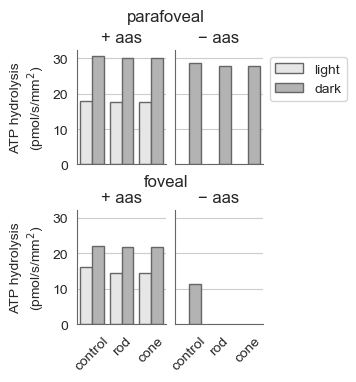

In [23]:
# create a barplot
# change order 
# define the palette with grey and white colors
import seaborn as sns
import matplotlib.pyplot as plt

my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 
results_long1 = results_long1[results_long1['single/combined'].isin(['combined'])]

cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)
# set whitegrid style
sns.set_style("whitegrid")

g = sns.catplot(data=results_long1, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
            hue='light/dark',\
            kind='bar', \
            col='aa_ratio',\
            row = 'region',\
            ci='sd',\
            palette = my_palette, legend=False)

# rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('')

plt.gcf().set_size_inches(2,3)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# CHANGE X tick labels
plt.gcf().axes[0].set_xticklabels(['control','rod','cone'])

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['+ aas', '− aas','+ aas','− aas']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)
    
# create text above first row
plt.gcf().text(0.5, 1.08, 'parafoveal', ha='center', va='center', fontsize = 12)
# create text above second row
plt.gcf().text(0.5, 0.53, 'foveal', ha='center', va='center', fontsize = 12)

# increase space between rows
plt.subplots_adjust(hspace = 0.4)

# move legend to the right
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[2].legend().remove()
plt.gcf().axes[3].legend().remove()
plt.gcf().axes[1].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# increase space between plots
plt.subplots_adjust(wspace = 0.1)

# create results folder
# save figure in results folder in user folder
plt.savefig(results_folder + '/ATP_FBA_aas_noaas_combined_foveal_parafoveal.png', dpi=300, bbox_inches='tight')

In [24]:
#########################################################################################
########################## FOVEAL CONE / PARAFOVEAL ROD #################################
#########################################################################################


# from results_long2 select all entries for RPE-PR cone that have region foveal and for RPE-PR rod that have region parafoveal, and all control models
results_long2 = results_long[(results_long['cell'].isin(['RPE - PR cone']) & results_long['region'].isin(['foveal']))\
                              | (results_long['cell'].isin(['RPE - PR rod']) & results_long['region'].isin(['parafoveal']))\
                                | (results_long['cell'].isin(['RPE - PR control']))]

# make one new column in which cell + region are combined
results_long2['cell_region'] = results_long2['cell'] + ' ' + results_long2['region']

results_long2

C:\Users\prins\AppData\Local\Temp\ipykernel_19276\100697137.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long2['cell_region'] = results_long2['cell'] + ' ' + results_long2['region']


,model,light/dark_region,ATP hydrolysis (pmol/s/mm^2),single/combined,aa_ratio,cell,region,light/dark,cell_region
5,mod_RPE_PRcontrol2.0,light_parafoveal,18.415882,combined,2.0,RPE - PR control,parafoveal,light,RPE - PR control parafoveal
6,mod_RPE_PRcontrol1.0,light_parafoveal,17.808396,combined,1.0,RPE - PR control,parafoveal,light,RPE - PR control parafoveal
7,mod_RPE_PRcontrol0.5,light_parafoveal,16.935432,combined,0.5,RPE - PR control,parafoveal,light,RPE - PR control parafoveal
8,mod_RPE_PRcontrol0.25,light_parafoveal,9.699103,combined,.25,RPE - PR control,parafoveal,light,RPE - PR control parafoveal
9,mod_RPE_PRcontrol0.0,light_parafoveal,NaN,combined,0.0,RPE - PR control,parafoveal,light,RPE - PR control parafoveal
10,mod_RPE_PRrod_Lukowski2.0,light_parafoveal,17.929800,combined,2.0,RPE - PR rod,parafoveal,light,RPE - PR rod parafoveal
11,mod_RPE_PRrod_Lukowski1.0,light_parafoveal,17.585718,combined,1.0,RPE - PR rod,parafoveal,light,RPE - PR rod parafoveal
12,mod_RPE_PRrod_Lukowski0.5,light_parafoveal,8.248779,combined,0.5,RPE - PR rod,parafoveal,light,RPE - PR rod parafoveal
13,mod_RPE_PRrod_Lukowski0.25,light_parafoveal,NaN,combined,.25,RPE - PR rod,parafoveal,light,RPE - PR rod parafoveal
14,mod_RPE_PRrod_Lukowski0.0,light_parafoveal,NaN,combined,0.0,RPE - PR rod,parafoveal,light,RPE - PR rod parafoveal


C:\Users\prins\AppData\Local\Temp\ipykernel_19276\4173970338.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long1['aa_ratio'] = pd.Categorical(results_long1['aa_ratio'], categories=aa_order, ordered=True)
C:\Users\prins\AppData\Local\Temp\ipykernel_19276\4173970338.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)
C:\Users\prins\AppData\Local\Temp\ipykernel_19276\4173970338.py:17: FutureWa

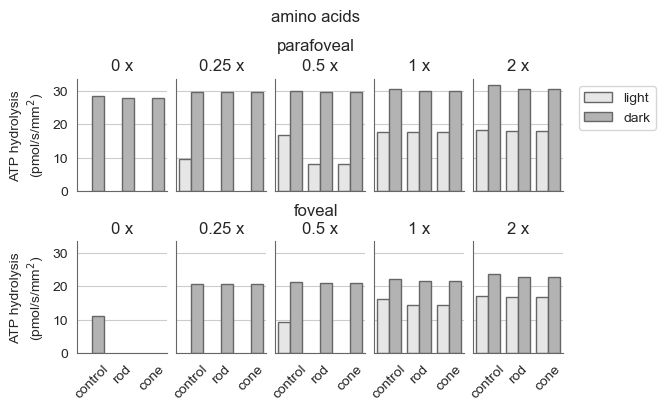

In [25]:
# create a barplot
# change order 
# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)


# select only rows with 1.0 or 0.0 in aa_ratio column
results_long1 = results_long[results_long['single/combined'].isin(['combined'])]
cell_order = ['RPE - PR control','RPE - PR rod','RPE - PR cone']
aa_order = ['0.0','.25','0.5','1.0','2.0']
# convert aa_ratio column to categorical variable with desired order
results_long1['aa_ratio'] = pd.Categorical(results_long1['aa_ratio'], categories=aa_order, ordered=True)
results_long1['cell'] = pd.Categorical(results_long1['cell'], categories = cell_order, ordered = True)


g = sns.catplot(data=results_long1, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
            hue='light/dark',\
            kind='bar', \
            col='aa_ratio',\
            row = 'region',\
            ci='sd',\
            palette=my_palette, legend=False)

plt.gcf().axes[0].set_xticklabels(cell_order)
plt.xticks(rotation=90)
plt.gcf().set_size_inches(5,3)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)


# REMOVE x axis title
ax.set_xlabel('') 

# increase space between plots
plt.subplots_adjust(wspace = 0.1)

# create suptitle
plt.suptitle('amino acids', y = 1.2)
# create text above first row
plt.gcf().text(0.5, 1.08, 'parafoveal', ha='center', va='center', fontsize = 12)
# create text above second row
plt.gcf().text(0.5, 0.53, 'foveal', ha='center', va='center', fontsize = 12)

# change titles of subplots
titles = ['0 x', '0.25 x', '0.5 x','1 x','2 x',\
          '0 x', '0.25 x', '0.5 x','1 x','2 x']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# Remove legends from both subplots for all axes
for ax in plt.gcf().axes:
    ax.legend().remove()

# rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('')
    
# CHANGE X tick labels
plt.gcf().axes[1].set_xticklabels(['control','rod','cone'])

# increase space between rows
plt.subplots_adjust(hspace = 0.45)

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(5.5, 1.0))

# save figure in results folder in user folder
plt.savefig(results_folder +  '/ATP_FBA_levels_aas_foveal_parafoveal.png', dpi=300, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_19276\2729890246.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.catplot(data=results_long1, x='cell', \


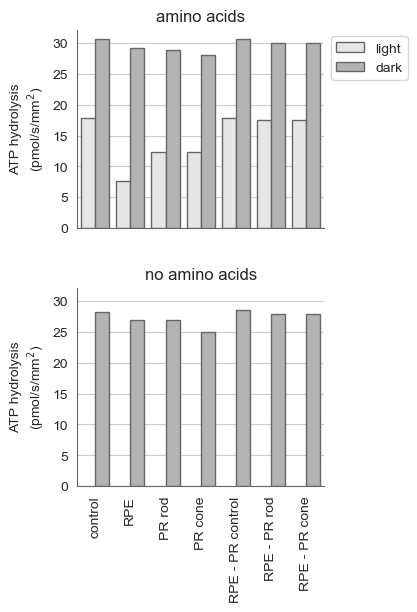

In [26]:
# create a barplot
# change order 

# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

cell_order = ['control', 'RPE','PR rod','PR cone','RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long['cell'] = pd.Categorical(results_long['cell'], categories=cell_order, ordered=True)


# select only rows with 1.0 or 0.0 in aa_ratio column parafoveal only
results_long1 = results_long[results_long['region'].isin(['parafoveal'])]
results_long1 = results_long1[results_long1['aa_ratio'].isin(['1.0','0.0'])] 

sns.catplot(data=results_long1, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            row='aa_ratio',\
            ci='sd',\
            palette=my_palette, \
            legend=False)

plt.xticks(rotation=90)
plt.gcf().set_size_inches(3,5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['amino acids', 'no amino acids']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# Remove legends from both subplots
plt.gcf().axes[0].legend().remove()
plt.gcf().axes[1].legend().remove()

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# save figure in results folder in user folder
plt.savefig(results_folder +  '/ATP_FBA_aas_noaas_all.png', dpi=300, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_19276\3932306377.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=results_long1, x='cell', \


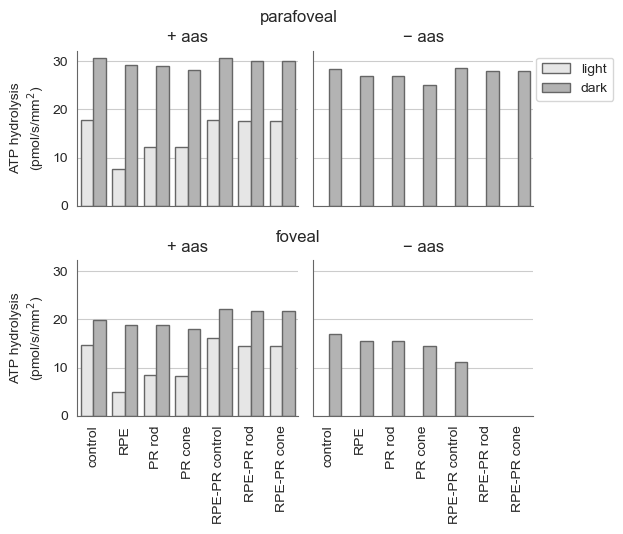

In [27]:
# create a barplot
# change order 
# whitegrid
sns.set_style("whitegrid")

# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

cell_order = ['control', 'RPE','PR rod','PR cone','RPE - PR control','RPE - PR rod','RPE - PR cone']
results_long['cell'] = pd.Categorical(results_long['cell'], categories=cell_order, ordered=True)

# select only rows with 1.0 or 0.0 in aa_ratio column parafoveal only
results_long1 = results_long[results_long['aa_ratio'].isin(['1.0','0.0'])] 

g = sns.catplot(data=results_long1, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            row='region',\
            col = 'aa_ratio',\
            ci='sd',\
            palette=my_palette, \
            legend=False)

plt.xticks(rotation=90)
plt.gcf().set_size_inches(5,4)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['+ aas', '− aas','+ aas', '− aas']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

# rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

# set xticklabels
plt.gcf().axes[0].set_xticklabels(['control','RPE','PR rod','PR cone','RPE-PR control','RPE-PR rod','RPE-PR cone'])
    
# Remove all legends from both subplots
for ax in plt.gcf().axes:
    ax.legend().remove()

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(2.05, 1.0))

# create text above first row
plt.gcf().text(0.5, 1.05, 'parafoveal', ha='center', va='center', fontsize = 12)
# create text above second row
plt.gcf().text(0.5, 0.5, 'foveal', ha='center', va='center', fontsize = 12)

# increase space between rows
plt.subplots_adjust(hspace = 0.35)

# save figure in results folder in user folder
plt.savefig(results_folder +  '/ATP_FBA_aas_noaas_all_foveal_parafoveal.png', dpi=300, bbox_inches='tight')

C:\Users\prins\AppData\Local\Temp\ipykernel_19276\3057700098.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g=sns.catplot(data=results_long2, x='cell', \


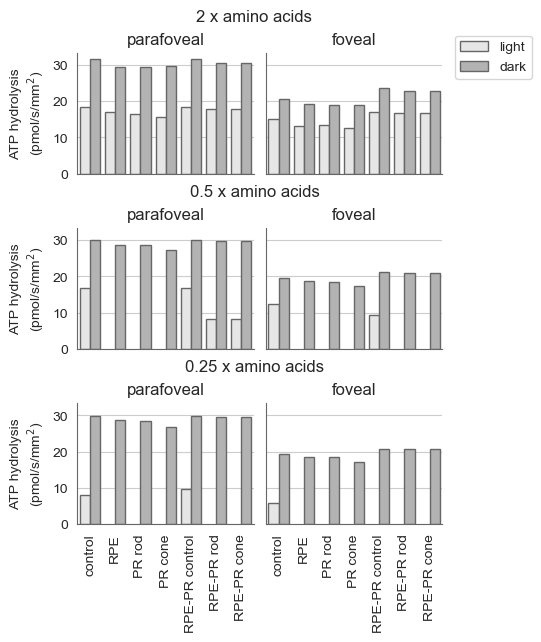

In [28]:
# create a barplot
# change order 
# define the palette with grey and white colors
my_palette = {'dark': (0.7, 0.7, 0.7), 'light': (0.9, 0.9, 0.9)}
dg =(0.4, 0.4, 0.4)

# select only rows with 1.0 or 0.0 in aa_ratio column
results_long2 = results_long[results_long['aa_ratio'].isin(['2.0','0.5','.25'])] 

cell_order = ['control', 'RPE','PR rod','PR cone','RPE - PR control','RPE - PR rod','RPE - PR cone']

g=sns.catplot(data=results_long2, x='cell', \
            y='ATP hydrolysis (pmol/s/mm^2)',\
             hue='light/dark',\
            kind='bar', \
            row='aa_ratio',\
            col = 'region',\
            ci='sd',\
            palette=my_palette, legend=False)

plt.gcf().axes[0].set_xticklabels(cell_order)
plt.gcf().set_size_inches(4,5)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# change y-axis label for all subplots
for ax in plt.gcf().axes:
    ax.set_ylabel('ATP hydrolysis\n(pmol/s/mm$^2$)')
    ax.spines['bottom'].set_color(dg)
    ax.spines['left'].set_color(dg)
    for p in ax.patches:
        p.set_edgecolor(dg)
        p.set_linewidth(1)

# REMOVE x axis title
ax.set_xlabel('') 

# increase space betwen plots
plt.subplots_adjust(hspace = 0.3)

# change titles of subplots
titles = ['parafoveal', 'foveal','parafoveal', 'foveal','parafoveal', 'foveal']
for ax, title in zip(plt.gcf().axes, titles):
    ax.set_title(title)

plt.gcf().text(0.5, 1.05, '2 x amino acids', ha='center', va='center', fontsize = 12)
plt.gcf().text(0.5, 0.7, '0.5 x amino acids', ha='center', va='center', fontsize = 12)
plt.gcf().text(0.5, 0.35, '0.25 x amino acids', ha='center', va='center', fontsize = 12)

# increase space between rows
plt.subplots_adjust(hspace = 0.45)

# Remove legends from both subplots
for ax in plt.gcf().axes:
    ax.legend().remove()

    # rotate x-axis labels for all subplots
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

# add xtick labels
plt.gcf().axes[1].set_xticklabels(['control','RPE','PR rod','PR cone','RPE-PR control','RPE-PR rod','RPE-PR cone'])

# move legend to the right
plt.gcf().axes[0].legend(loc='upper left', bbox_to_anchor=(2.1, 1.2))

# save figure in results folder in user folder
plt.savefig(results_folder + '/ATP_FBA_aas.png', dpi=300, bbox_inches='tight')

In [29]:
def my_range(start, end, step):
    return [round(start + i * step, 1) for i in range(int((end - start) / step) + 1)]

multiplication_factors = my_range(3,6,0.1)

In [30]:
# # uncomment to run again (takes ~ 60 min)

# ####################################################################################################
# ###########                                LACTATE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################


# multiplication_factors_light = my_range(2.5,6,0.1)
# multiplication_factors_dark = my_range(7,15,0.1)

# # light
# lactate_RPE_light = 3.79
# lactate_PR_light = 0.41
# lactate_RPEp_light = lactate_RPE_light/(lactate_RPE_light+lactate_PR_light)
# lactate_PRp_light = lactate_PR_light/(lactate_RPE_light+lactate_PR_light)

# # dark
# lactate_RPE_dark = 7.18
# lactate_PR_dark = 1.16
# lactate_RPEp_dark = lactate_RPE_dark/(lactate_RPE_dark+lactate_PR_dark)
# lactate_PRp_dark = lactate_PR_dark/(lactate_RPE_dark+lactate_PR_dark)

# # light
# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# # dark
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.84, 'RPE')
#             m = open_blood_exchange(m,blood_ratio0,  -0.20, 'PR')

#             lactate_RPE = lactate_RPEp_light*i
#             lactate_PR = lactate_PRp_light*i
            
#             ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
#                       'MAR09034_RPE':(-1.84,-1.84),\
#                       'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
#                      'MAR04896_PR_RPE':(-2.19,-2.19),\
#                       'MAR09048_PR':(-0.27,-0.27),\
#                       'MAR09034_PR':(-0.20,-0.20),\
#                       'MAR09135_PR':(lactate_PR,lactate_PR)}
#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.84, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.20, 'PR')

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -4.14, 'RPE')   
#             m = open_blood_exchange(m,blood_ratio0,  -0.67, 'PR')

#             lactate_RPE = lactate_RPEp_dark*i
#             lactate_PR = lactate_PRp_dark*i

#             ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
#                       'MAR09034_RPE':(-4.14,-4.14),\
#                       'MAR04896_PR_RPE':(-3.18,-3.18),\
#                       'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
#                       'MAR09048_PR':(-0.56,-0.56),\
#                       'MAR09034_PR':(-0.67,-0.67),\
#                       'MAR09135_PR':(lactate_PR,lactate_PR)}
#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -4.14, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.67, 'PR')
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas

# df_light_no_aas.to_pickle(pickle_folder + '/df_light_no_aas.pkl')
# df_light_aas.to_pickle(pickle_folder + '/df_light_aas.pkl')
# df_dark_no_aas.to_pickle(pickle_folder + '/df_dark_no_aas.pkl')
# df_dark_aas.to_pickle(pickle_folder + '/df_dark_aas.pkl')

In [31]:
# # # # uncomment to run again (takes ~ 80 min)
# # # ####################################################################################################
# # # ###########                                   FOVEAL                                   #############
# # # ####################################################################################################


# # # ####################################################################################################
# # # ###########                                LACTATE SWEEPS                              #############
# # # ###########                                 LIGHT / DARK                               #############
# # # ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# # # ####################################################################################################


# # multiplication_factors_light = my_range(0,4.5,0.1)
# # multiplication_factors_dark = my_range(0,9,0.1)


# # ##############################################################
# # ##############     CC exchange  (CC --> RPE)  ################
# # ####  inner retina exchange  (retina vasculature --> PR)  ####
# # ##############################################################

# # # MAR09048: oxygen 
# # # MAR09034: glucose 
# # # MAR09135: lactate 

# # # FOVEAL
# # FOVEAL
# ex_bounds_dark_foveal = {'MAR09048_RPE':(-2.72,-2.72),\
#                      'MAR04896_PR_RPE':(-2.42,-2.42),\
#                       'MAR09034_RPE':(-2.89,-2.89),\
#                       'MAR09135_RPE':(5,5)}          

# ex_bounds_light_foveal = {'MAR09048_RPE':(-2.34,-2.34),\
#                       'MAR04896_PR_RPE':(-2.04,-2.04),\
#                       'MAR09034_RPE':(-1.51,-1.51),\
#                       'MAR09135_RPE':(3.11,3.11)}
	 
# # FOVEAL
# single_ex_bounds_dark_foveal = {'MAR09048':(-2.72,-2.72),\
#                       'MAR09034':(-2.89,-2.89),\
#                         'MAR09135':(5.00,5.00)}

# single_ex_bounds_light_foveal = {'MAR09048':(-2.34,-2.34),\
#                        'MAR09034':(-1.51,-1.51),\
#                         'MAR09135':(3.11,3.11)}

# single_ex_bounds_light_foveal = {'MAR09048':(-2.34,-2.34),\
#                        'MAR09034':(-1.51,-1.51),\
#                         'MAR09135':(3.11,3.11)}

# single_ex_bounds_dark_foveal = {'MAR09048':(-2.42,-2.42),\
#                       'MAR09034':(-2.89,-2.89),\
#                         'MAR09135':(5.00,5.00)}

# # light
# lactate_RPE_light = 2.76
# lactate_PR_light = 0.34
# lactate_RPEp_light = lactate_RPE_light/(lactate_RPE_light+lactate_PR_light)
# lactate_PRp_light = lactate_PR_light/(lactate_RPE_light+lactate_PR_light)

# # dark
# lactate_RPE_dark = 4.25
# lactate_PR_dark = 0.75
# lactate_RPEp_dark = lactate_RPE_dark/(lactate_RPE_dark+lactate_PR_dark)
# lactate_PRp_dark = lactate_PR_dark/(lactate_RPE_dark+lactate_PR_dark)

# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}



# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.34, 'RPE')
#             m = open_blood_exchange(m,blood_ratio0,  -0.17, 'PR')

#             lactate_RPE = lactate_RPEp_light*i
#             lactate_PR = lactate_PRp_light*i
#             ex_bounds_light = {'MAR09048_RPE':(-1.81,-1.81),\
#                           'MAR04896_PR_RPE':(-1.51,-1.51),\
#                           'MAR09034_RPE':(-1.34,-1.34),\
#                           'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
#                           'MAR09048_PR':(-0.22,-0.22),\
#                           'MAR09034_PR':(-0.17,-0.17),\
#                           'MAR09135_PR':(lactate_PR,lactate_PR)}

#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.34, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.17, 'PR')

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0,-2.45, 'RPE')   
#             m = open_blood_exchange(m,blood_ratio0,  -0.67, 'PR')

#             lactate_RPE = lactate_RPEp_dark*i
#             lactate_PR = lactate_PRp_dark*i
#             ex_bounds_dark = {'MAR09048_RPE':(-2.06,-2.06),\
#                                  'MAR04896_PR_RPE':(-1.76,-1.76),\
#                                   'MAR09034_RPE':(-2.45,-2.45),\
#                                   'MAR09135_RPE':(lactate_RPE,lactate_RPE),\
#                                   'MAR09048_PR':(-0.36,-0.36),\
#                                   'MAR09034_PR':(-0.43,-0.43),\
#                                   'MAR09135_PR':(lactate_PR,lactate_PR)}      

#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.45, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.67, 'PR')
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas

# df_light_no_aas_foveal.to_pickle(pickle_folder + '/df_light_no_aas_foveal.pkl')
# df_light_aas_foveal.to_pickle(pickle_folder + '/df_light_aas_foveal.pkl')
# df_dark_no_aas_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_foveal.pkl')
# df_dark_aas_foveal.to_pickle(pickle_folder + '/df_dark_aas_foveal.pkl')

In [56]:
# # # uncomment to run again (takes ~ 80 min)
# # ####################################################################################################
# # ###########                                   FOVEAL                                   #############
# # ####################################################################################################


# # ####################################################################################################
# # ###########                                LACTATE SWEEPS                              #############
# # ###########                                 LIGHT / DARK                               #############
# # ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# # ####################################################################################################


# multiplication_factors_light = my_range(0,4.5,0.1)
# multiplication_factors_dark = my_range(0,9,0.1)


# ##############################################################
# ##############     CC exchange  (CC --> RPE)  ################
# ####  inner retina exchange  (retina vasculature --> PR)  ####
# ##############################################################

# # MAR09048: oxygen 
# # MAR09034: glucose 
# # MAR09135: lactate 


# # FOVEAL
# ex_bounds_dark_foveal = {'MAR09048_RPE':(-2.72,-2.72),\
#                      'MAR04896_PR_RPE':(-2.42,-2.42),\
#                       'MAR09034_RPE':(-2.89,-2.89),\
#                       'MAR09135_RPE':(5,5)}          

# ex_bounds_light_foveal = {'MAR09048_RPE':(-2.34,-2.34),\
#                       'MAR04896_PR_RPE':(-2.04,-2.04),\
#                       'MAR09034_RPE':(-1.51,-1.51),\
#                       'MAR09135_RPE':(3.11,3.11)}
	 
# # FOVEAL

# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}


# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
#             m = open_blood_exchange(m,blood_ratio0, -1.51, 'RPE')
#             for ex in ex_bounds_light_foveal.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds
#             model.reactions.get_by_id('MAR09135_RPE').bounds = (i,i)
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.51, 'RPE')
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:
#             m = open_blood_exchange(m,blood_ratio0,-2.89, 'RPE')   
#             for ex in ex_bounds_dark_foveal.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex]
#             model.reactions.get_by_id('MAR09135_RPE').bounds = (i,i)
#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.89, 'RPE')
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]
#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas

# df_light_no_aas_foveal.to_pickle(pickle_folder + '/df_light_no_aas_foveal.pkl')
# df_light_aas_foveal.to_pickle(pickle_folder + '/df_light_aas_foveal.pkl')
# df_dark_no_aas_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_foveal.pkl')
# df_dark_aas_foveal.to_pickle(pickle_folder + '/df_dark_aas_foveal.pkl')

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

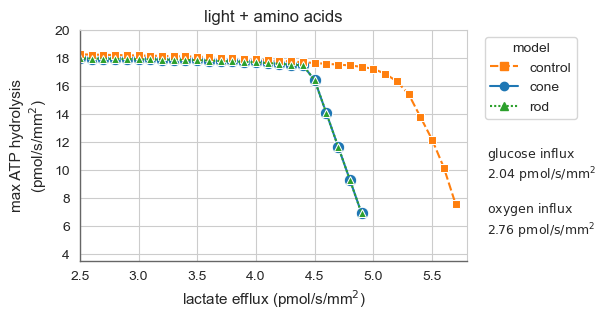

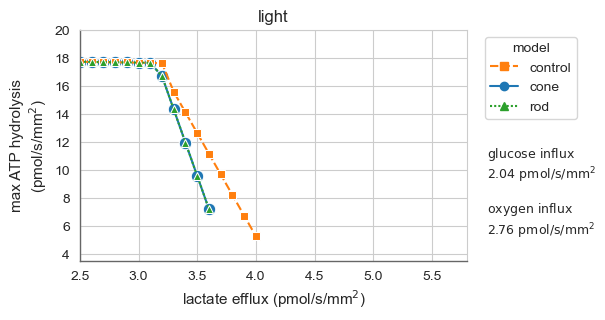

In [57]:
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                  PARAFOVEAL                                #############
####################################################################################################


# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas = pd.read_pickle(pickle_folder +  '/df_light_no_aas.pkl')
df_light_aas = pd.read_pickle(pickle_folder +  '/df_light_aas.pkl')
df_dark_no_aas = pd.read_pickle(pickle_folder +  '/df_dark_no_aas.pkl')
df_dark_aas = pd.read_pickle(pickle_folder +  '/df_dark_aas.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

# import MultipleLocator
from matplotlib.ticker import MultipleLocator

# LACTATE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_lactate_sweep_parafoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_lactate_sweep_parafoveal.xlsx')  


# LACTATE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3.5,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_lactate_sweep_parafoveal.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_lactate_sweep_parafoveal.xlsx')  

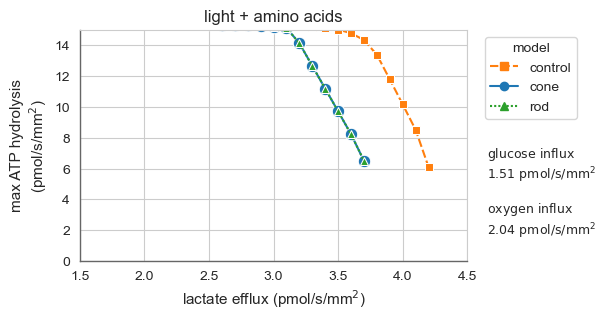

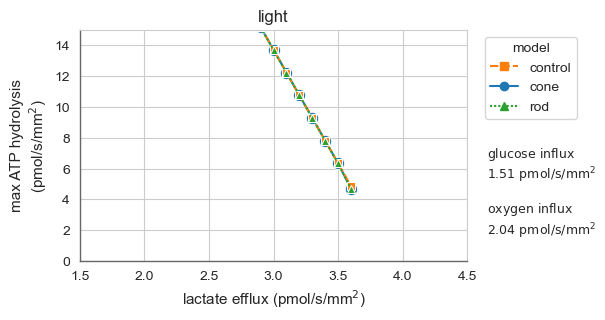

In [58]:
####################################################################################################
###########                                LACTATE SWEEPS                              #############
###########                                  FOVEAL                                   #############
####################################################################################################

# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas_foveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_foveal.pkl')
df_light_aas_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_foveal.pkl')
df_dark_no_aas_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_foveal.pkl')
df_dark_aas_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_foveal.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

# import MultipleLocator
from matplotlib.ticker import MultipleLocator

# LACTATE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(0,15)
ax.set_xlim(1.5,4.5)


# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$1.51\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_lactate_sweep_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/light_aas_lactate_sweep_foveal.xlsx')  


# LACTATE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)


ax.set_ylim(0,15)
ax.set_xlim(1.5,4.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_lactate_sweep_foveal.png', bbox_inches='tight')
df_light_no_aas_foveal.to_excel(results_folder + '/light_no_aas_lactate_sweep_foveal.xlsx')  


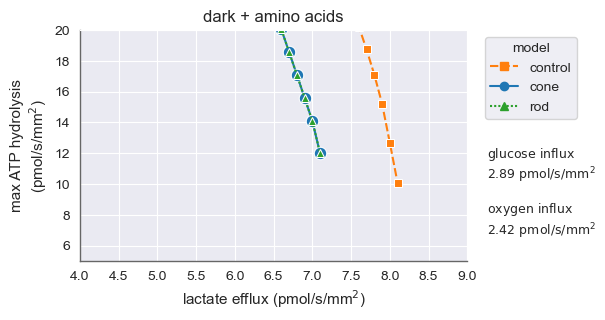

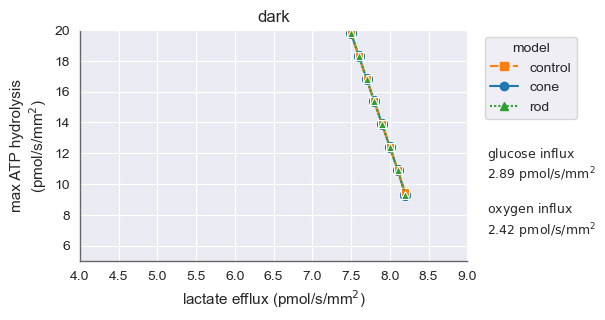

In [59]:
# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

##############################################################
#######    total exchange (for single models)        #########
##############################################################

# FOVEAL
single_ex_bounds_dark_foveal = {'MAR09048':(-2.42,-2.42),\
                      'MAR09034':(-2.89,-2.89),\
                        'MAR09135':(5.00,5.00)}

single_ex_bounds_light_foveal = {'MAR09048':(-2.34,-2.34),\
                       'MAR09034':(-1.51,-1.51),\
                        'MAR09135':(3.11,3.11)}


# LACTATE SWEEP FIGURES DARK
results_folder = create_folder('results', 'paper','sweep', 'lactate')
# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(5,20)
ax.set_xlim(4,9)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.89\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.42\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))
    
fig.savefig(results_folder + '/dark_aas_lactate_sweep_foveal.png', bbox_inches='tight')
df_dark_aas_foveal.to_excel(results_folder + '/dark_aas_lactate_sweep_foveal.xlsx')  


# LACTATE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(5,20)
ax.set_xlim(4,9)
# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_foveal.png', bbox_inches='tight')
df_dark_no_aas_foveal.to_excel(results_folder + '/dark_no_aas_lactate_sweep_foveal.xlsx')  

In [60]:
# ####################################################################################################
# ###########                                GLUCOSE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################


# multiplication_factors_light = my_range(1,3,0.1)
# multiplication_factors_dark = my_range(2,5.5,0.1)


# # light
# glucose_RPE_light = 1.84
# glucose_PR_light = 0.2
# glucose_RPEp_light = glucose_RPE_light/(glucose_RPE_light+glucose_PR_light)
# glucose_PRp_light = glucose_PR_light/(glucose_RPE_light+glucose_PR_light)

# # dark
# glucose_RPE_dark = 4.14
# glucose_PR_dark = 0.67
# glucose_RPEp_dark = glucose_RPE_dark/(glucose_RPE_dark+glucose_PR_dark)
# glucose_PRp_dark = glucose_PR_dark/(glucose_RPE_dark+glucose_PR_dark)


# # light
# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# # dark
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.84, 'RPE')
#             m = open_blood_exchange(m,blood_ratio0,  -0.20, 'PR')

#             glucose_RPE = -glucose_RPEp_light*i
#             glucose_PR = -glucose_PRp_light*i
            
#             ex_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
#                       'MAR09034_RPE':(glucose_RPE,glucose_RPE),\
#                       'MAR04896_PR_RPE':(-2.19,-2.19),\
#                       'MAR09135_RPE':(3.79,3.79),\
#                       'MAR09048_PR':(-0.27,-0.27),\
#                       'MAR09034_PR':(glucose_PR,glucose_PR),\
#                       'MAR09135_PR':(.41,.41)}
#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.84, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.20, 'PR')

#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -4.14, 'RPE')   
#             m = open_blood_exchange(m,blood_ratio0,  -0.67, 'PR')

#             glucose_RPE = -glucose_RPEp_dark*i
#             glucose_PR = -glucose_PRp_dark*i

#             ex_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
#                       'MAR09034_RPE':(glucose_RPE,glucose_RPE),\
#                      'MAR04896_PR_RPE':(-3.18,-3.18),\
#                       'MAR09135_RPE':(7.18,7.18),\
#                       'MAR09048_PR':(-0.56,-0.56),\
#                       'MAR09034_PR':(glucose_PR,glucose_PR),\
#                       'MAR09135_PR':(1.16,1.16)}
#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -4.14, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.67, 'PR')
           
#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
            
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas_glucose = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas_glucose = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas_glucose = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas_glucose = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # pickle df_light_no_aas_glucose, df_light_aas_glucose, df_dark_no_aas_glucose, df_dark_aas_glucose
# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
# df_light_no_aas_glucose.to_pickle(pickle_folder + '/df_light_no_aas_glucose.pkl')
# df_light_aas_glucose.to_pickle(pickle_folder +'/df_light_aas_glucose.pkl')
# df_dark_no_aas_glucose.to_pickle(pickle_folder + '/df_dark_no_aas_glucose.pkl')
# df_dark_aas_glucose.to_pickle(pickle_folder +'/df_dark_aas_glucose.pkl')


In [61]:
# # ####################################################################################################
# # ##########                                      FOVEAL                                   ###########  
# # ####################################################################################################

# # ####################################################################################################
# # ###########                                GLUCOSE SWEEPS                              #############
# # ###########                                 LIGHT / DARK                               #############
# # ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# # ####################################################################################################

# # MAR09048: oxygen 
# # MAR09034: glucose 
# # MAR09135: lactate 

# # FOVEAL

# multiplication_factors_light = my_range(0,8,0.1)
# multiplication_factors_dark = my_range(0,10,0.1)

# # light
# glucose_RPE_light = 1.34
# glucose_PR_light = 0.17
# glucose_RPEp_light = glucose_RPE_light/(glucose_RPE_light+glucose_PR_light)
# glucose_PRp_light = glucose_PR_light/(glucose_RPE_light+glucose_PR_light)

# # dark
# glucose_RPE_dark = 2.45
# glucose_PR_dark = 0.43
# glucose_RPEp_dark = glucose_RPE_dark/(glucose_RPE_dark+glucose_PR_dark)
# glucose_PRp_dark = glucose_PR_dark/(glucose_RPE_dark+glucose_PR_dark)


# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.34, 'RPE')
#             m = open_blood_exchange(m,blood_ratio0,  -0.17, 'PR')

#             glucose_RPE = -glucose_RPEp_light*i
#             glucose_PR = -glucose_PRp_light*i
            
#             ex_bounds_light = {'MAR09048_RPE':(-1.81,-1.81),\
#                                     'MAR04896_PR_RPE':(-1.51,-1.51),\
#                                     'MAR09034_RPE':(glucose_RPE,glucose_RPE),\
#                                     'MAR09135_RPE':(2.76,2.76),\
#                                     'MAR09048_PR':(-0.22,-0.22),\
#                                     'MAR09034_PR':(glucose_PR,glucose_PR),\
#                                     'MAR09135_PR':(0.34,0.34)}

#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.34, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.17, 'PR')

#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -2.45, 'RPE')   
#             m = open_blood_exchange(m,blood_ratio0,  -0.43, 'PR')

#             glucose_RPE = -glucose_RPEp_dark*i
#             glucose_PR = -glucose_PRp_dark*i
#             ex_bounds_dark = {'MAR09048_RPE':(-2.06,-2.06),\
#                                 'MAR04896_PR_RPE':(-1.76,-1.76),\
#                                 'MAR09034_RPE':(glucose_RPE,glucose_RPE),\
#                                 'MAR09135_RPE':(4.25,4.25),\
#                                 'MAR09048_PR':(-0.36,-0.36),\
#                                 'MAR09034_PR':(glucose_PR,glucose_PR),\
#                                 'MAR09135_PR':(0.75,0.75)}   

#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.45, 'RPE')
#             m = open_blood_exchange(m,blood_ratio,  -0.43, 'PR')
           
#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
            
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas


# df_light_no_aas_glucose_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_glucose_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_glucose_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_glucose_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # pickle df_light_no_aas_glucose, df_light_aas_glucose, df_dark_no_aas_glucose, df_dark_aas_glucose
# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
# df_light_no_aas_glucose_foveal.to_pickle(pickle_folder + '/df_light_no_aas_glucose_foveal.pkl')
# df_light_aas_glucose_foveal.to_pickle(pickle_folder +'/df_light_aas_glucose_foveal.pkl')
# df_dark_no_aas_glucose_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_glucose_foveal.pkl')
# df_dark_aas_glucose_foveal.to_pickle(pickle_folder +'/df_dark_aas_glucose_foveal.pkl')

In [62]:
# # # ####################################################################################################
# # # ##########                                      FOVEAL                                   ###########  
# # # ####################################################################################################

# # # ####################################################################################################
# # # ###########                                GLUCOSE SWEEPS                              #############
# # # ###########                                 LIGHT / DARK                               #############
# # # ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# # # ####################################################################################################

# # # MAR09048: oxygen 
# # # MAR09034: glucose 
# # # MAR09135: lactate 

# # # FOVEAL

# # FOVEAL
# ex_bounds_dark_foveal = {'MAR09048_RPE':(-2.72,-2.72),\
#                      'MAR04896_PR_RPE':(-2.42,-2.42),\
#                       'MAR09034_RPE':(-2.89,-2.89),\
#                       'MAR09135_RPE':(5,5)}          

# ex_bounds_light_foveal = {'MAR09048_RPE':(-2.34,-2.34),\
#                       'MAR04896_PR_RPE':(-2.04,-2.04),\
#                       'MAR09034_RPE':(-1.51,-1.51),\
#                       'MAR09135_RPE':(3.11,3.11)}


# multiplication_factors_light = my_range(0,8,0.1)
# multiplication_factors_dark = my_range(0,10,0.1)


# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in combined_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.51, 'RPE')
#             for ex in ex_bounds_light_foveal.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds
#             m.reactions.get_by_id('MAR09034_RPE').bounds = (-i,-i)
#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.51, 'RPE')
#             for ex in ex_bounds_light.keys(): 
#                 model.reactions.get_by_id(ex).bounds = ex_bounds_light[ex] # set exchange bounds
#             m.reactions.get_by_id('MAR09034_RPE').bounds = (-i,-i)
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -2.89, 'RPE')   

#             for ex in ex_bounds_dark_foveal.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
#             m.reactions.get_by_id('MAR09034_RPE').bounds = (-i,-i)
#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.89, 'RPE')
#             for ex in ex_bounds_dark.keys(): 
#                 m.reactions.get_by_id(ex).bounds = ex_bounds_dark[ex] # set exchange bounds
#             m.reactions.get_by_id('MAR09034_RPE').bounds = (-i,-i) 
#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas


# df_light_no_aas_glucose_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_glucose_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_glucose_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_glucose_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # pickle df_light_no_aas_glucose, df_light_aas_glucose, df_dark_no_aas_glucose, df_dark_aas_glucose
# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
# df_light_no_aas_glucose_foveal.to_pickle(pickle_folder + '/df_light_no_aas_glucose_foveal.pkl')
# df_light_aas_glucose_foveal.to_pickle(pickle_folder +'/df_light_aas_glucose_foveal.pkl')
# df_dark_no_aas_glucose_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_glucose_foveal.pkl')
# df_dark_aas_glucose_foveal.to_pickle(pickle_folder +'/df_dark_aas_glucose_foveal.pkl')

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

In [63]:
# load pickles
pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose = pd.read_pickle(pickle_folder +  '/df_light_no_aas_glucose.pkl')
df_light_aas_glucose = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose.pkl')
df_dark_no_aas_glucose = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose.pkl')
df_dark_aas_glucose = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose.pkl')

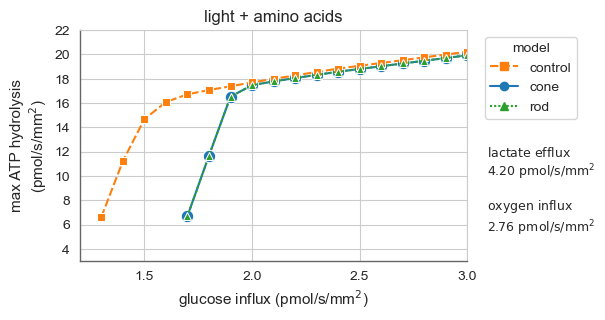

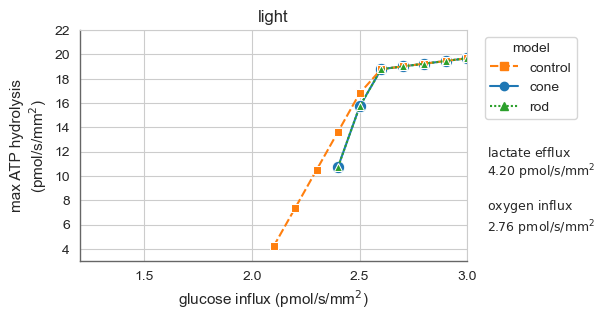

In [64]:
##############################################################
#######        PARAFOVEAL GLUCOSE SWEEP FIGURES        ########
##############################################################

results_folder = create_folder('results', 'paper','sweep', 'glucose')

# GLUCOSE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3,22)
ax.set_xlim(1.2,3)


# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$4.20\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_glucose_sweep_parafoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_glucose_sweep_parafoveal.xlsx')  

# GLUCOSE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(3,22)
ax.set_xlim(1.2,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_glucose_sweep_parafoveal.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_glucose_sweep_parafoveal.xlsx')  



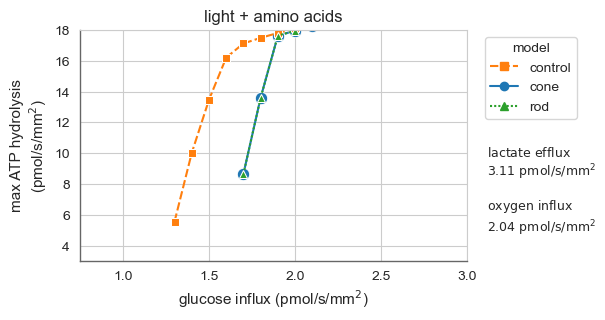

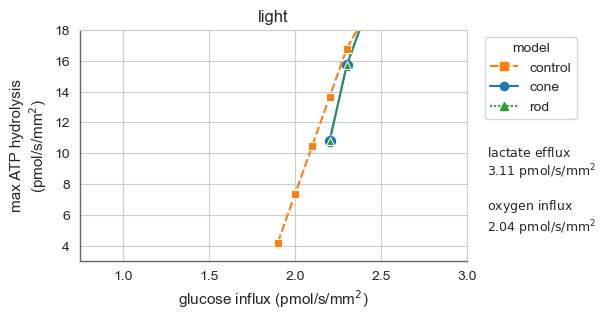

In [65]:
##############################################################
#######           FOVEAL GLUCOSE SWEEP FIGURES        ########
##############################################################

# load pickles
pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_glucose_foveal.pkl')
df_light_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose_foveal.pkl')
df_dark_no_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_foveal.pkl')
df_dark_aas_glucose_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_foveal.pkl')
results_folder = create_folder('results', 'paper','sweep', 'glucose')

# GLUCOSE SWEEP FIGURES LIGHT

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)


ax.set_ylim(3,18)
ax.set_xlim(.75,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$3.11\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_aas_glucose_sweep_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/light_aas_glucose_sweep_foveal.xlsx')  

# GLUCOSE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(3,18)
ax.set_xlim(.75,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/light_no_aas_glucose_sweep_foveal.png', bbox_inches='tight')
df_light_no_aas_foveal.to_excel(results_folder + '/light_no_aas_glucose_sweep_foveal.xlsx')  



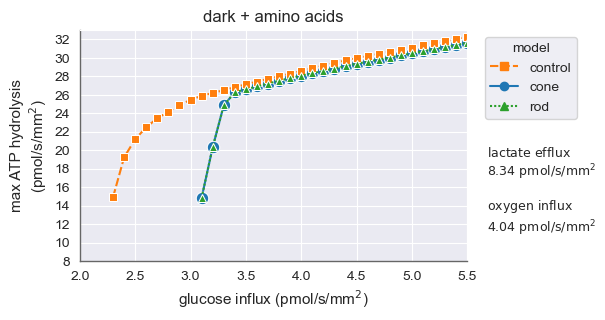

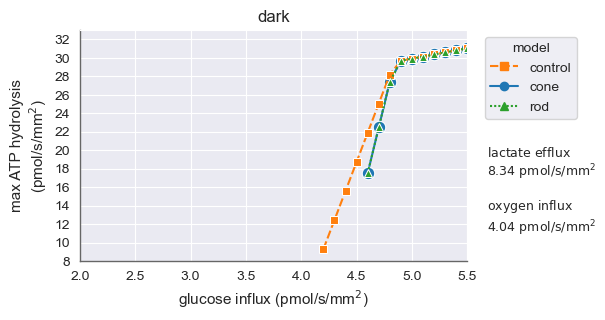

In [66]:
##############################################################
#######    PARAFOVEAL DARK GLUCOSE SWEEP FIGURES      ########
##############################################################


# GLUCOSE SWEEP FIGURES DARK
results_folder = create_folder('results', 'paper','sweep', 'glucose')

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(8,33)
ax.set_xlim(2,5.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$8.34\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))
    
fig.savefig(results_folder + '/dark_aas_glucose_sweep.png', bbox_inches='tight')
df_dark_aas_glucose.to_excel(results_folder + '/dark_aas_glucose_sweep.xlsx')  

# GLUCOSE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_glucose,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(8,33)
ax.set_xlim(2,5.5)
# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep_parafoveal.png', bbox_inches='tight')
df_dark_no_aas_glucose.to_excel(results_folder + '/dark_no_aas_glucose_sweep_parafoveal.xlsx')  


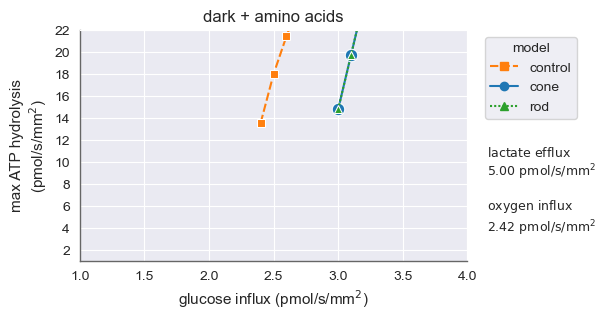

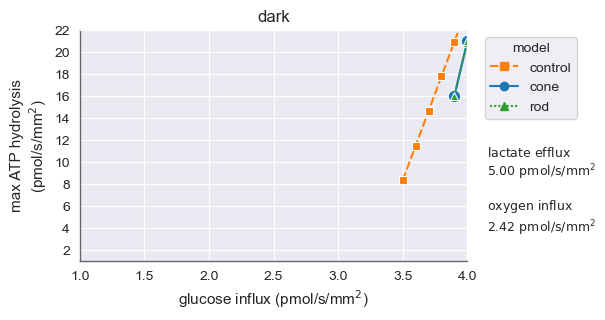

In [67]:
##############################################################
#######        FOVEAL DARK GLUCOSE SWEEP FIGURES      ########
##############################################################

# GLUCOSE SWEEP FIGURES DARK
results_folder = create_folder('results', 'paper','sweep', 'glucose')

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(1,22)
ax.set_xlim(1,4)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$5.00\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.42\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))
    
fig.savefig(results_folder + '/dark_aas_glucose_sweep_foveal.png', bbox_inches='tight')
df_dark_aas_glucose_foveal.to_excel(results_folder + '/dark_aas_glucose_sweep_foveal.xlsx')  

# GLUCOSE SWEEP

# import plt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_glucose_foveal,markers=['o','s','^'],ax=ax)
#change marker size
ax.lines[0].set_markersize(9)
ax.lines[1].set_markersize(6)
ax.lines[2].set_markersize(6)

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(1,22)
ax.set_xlim(1,4)
# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .5, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

# change labels of legend
handles, labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[2]]
labels = ['control', 'cone', 'rod']

ax.legend(handles, labels, title='model', loc='upper right',bbox_to_anchor=(1.3, 1.0))

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep_foveal.png', bbox_inches='tight')
df_dark_no_aas_glucose_foveal.to_excel(results_folder + '/dark_no_aas_glucose_sweep_foveal.xlsx')  

In [68]:
orange =  (1.0, 0.4980392156862745, 0.054901960784313725)
blue =  (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
green =  (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
red = (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
purple = (0.5803921568627451, 0.403921568627451, 0.7411764705882353)

In [69]:
# # uncomment to run again (takes ~ 10 min)

# ####################################################################################################
# ###########                                LACTATE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################

# def set_rxn_bounds(mod,rxn_dict):

#     for key in list(rxn_dict.keys()):
#         if key + '_PR' in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key + '_PR').bounds = rxn_dict[key]
#         elif key + '_RPE' in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key + '_RPE').bounds = rxn_dict[key]
#         elif key in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key).bounds = rxn_dict[key]
#         else: 
#             print(key + ' not in model')
#     return mod

# multiplication_factors_light = my_range(2.5,6,0.1)
# multiplication_factors_dark = my_range(7,15,0.1)

# # light
# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# # dark
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -2.04, '')
            
#             ex_bounds_light =    {'MAR09048':(-2.76,-2.76),\
#                                   'MAR09034':(-2.04,-2.04),\
#                                   'MAR09135':(i,i)}

#             m = set_rxn_bounds(m,ex_bounds_light)

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.04, '')

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -4.81, '')   

#             ex_bounds_dark =  {'MAR09048':(-4.04,-4.04),\
#                                   'MAR09034':(-4.81,-4.81),\
#                                   'MAR09135':(i,i)}
            
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -4.81, '')   
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas_lactate_single = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas_lactate_single = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas_lactate_single = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas_lactate_single = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
# df_light_no_aas_lactate_single.to_pickle(pickle_folder +  '/df_light_no_aas_lactate_single.pkl')
# df_light_aas_lactate_single.to_pickle(pickle_folder +  '/df_light_aas_lactate_single.pkl')
# df_dark_no_aas_lactate_single.to_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single.pkl')
# df_dark_aas_lactate_single.to_pickle(pickle_folder +  '/df_dark_aas_lactate_single.pkl')

In [70]:
# # uncomment to run again (takes ~ 10 min)

# ####################################################################################################
# ###########                                LACTATE SWEEPS                              #############
# ###########                                 FOVEAL                                     #############
# ####################################################################################################


# def set_rxn_bounds(mod,rxn_dict):

#     for key in list(rxn_dict.keys()):
#         if key + '_PR' in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key + '_PR').bounds = rxn_dict[key]
#         elif key + '_RPE' in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key + '_RPE').bounds = rxn_dict[key]
#         elif key in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key).bounds = rxn_dict[key]
#         else: 
#             print(key + ' not in model')
#     return mod

# multiplication_factors_light = my_range(0,4.5,0.1)
# multiplication_factors_dark = my_range(0,9,0.1)

# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.51, '')
            
#             ex_bounds_light= {'MAR09048':(-2.34,-2.34),\
#                        'MAR09034':(-1.51,-1.51),\
#                         'MAR09135':(i,i)}
#             m = set_rxn_bounds(m,ex_bounds_light)

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.51, '')

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -2.89, '')   

#             ex_bounds_dark = {'MAR09048':(-2.42,-2.42),\
#                       'MAR09034':(-2.89,-2.89),\
#                         'MAR09135':(i,i)}
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.89, '')   
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_lactate_single_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_lactate_single_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_lactate_single_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_lactate_single_foveal = pd.DataFrame(results_dict_dark_aa_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
# df_light_no_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_light_no_aas_lactate_single_foveal.pkl')
# df_light_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_light_aas_lactate_single_foveal.pkl')
# df_dark_no_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single_foveal.pkl')
# df_dark_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_dark_aas_lactate_single_foveal.pkl')

In [72]:
# # uncomment to run again (takes ~ 10 min)

# ####################################################################################################
# ###########                                LACTATE SWEEPS                              #############
# ###########                                 FOVEAL                                     #############
# ####################################################################################################


# def set_rxn_bounds(mod,rxn_dict):

#     for key in list(rxn_dict.keys()):
#         if key + '_PR' in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key + '_PR').bounds = rxn_dict[key]
#         elif key + '_RPE' in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key + '_RPE').bounds = rxn_dict[key]
#         elif key in [r.id for r in mod.reactions]:
#             mod.reactions.get_by_id(key).bounds = rxn_dict[key]
#         else: 
#             print(key + ' not in model')
#     return mod


# # FOVEAL
# ex_bounds_dark_foveal_single = {'MAR09048':(-2.72,-2.72),\
#                       'MAR09034':(-2.89,-2.89),\
#                       'MAR09135':(5,5)}          

# ex_bounds_light_foveal_single = {'MAR09048':(-2.34,-2.34),\
#                       'MAR09034':(-1.51,-1.51),\
#                       'MAR09135':(3.11,3.11)}
	

# multiplication_factors_light = my_range(0,4.5,0.1)
# multiplication_factors_dark = my_range(0,9,0.1)

# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.51, '')
            
#             ex_bounds_light= {'MAR09048':(-2.34,-2.34),\
#                        'MAR09034':(-1.51,-1.51),\
#                         'MAR09135':(i,i)}
#             m = set_rxn_bounds(m,ex_bounds_light)

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.51, '')

#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -2.89, '')   

#             ex_bounds_dark = {'MAR09048':(-2.72,-2.72),\
#                       'MAR09034':(-2.89,-2.89),\
#                         'MAR09135':(i,i)}
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.89, '')   
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_lactate_single_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_lactate_single_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_lactate_single_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_lactate_single_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder
# results_folder = create_folder('results', 'paper','sweep', 'lactate')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
# df_light_no_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_light_no_aas_lactate_single_foveal.pkl')
# df_light_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_light_aas_lactate_single_foveal.pkl')
# df_dark_no_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single_foveal.pkl')
# df_dark_aas_lactate_single_foveal.to_pickle(pickle_folder +  '/df_dark_aas_lactate_single_foveal.pkl')


c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

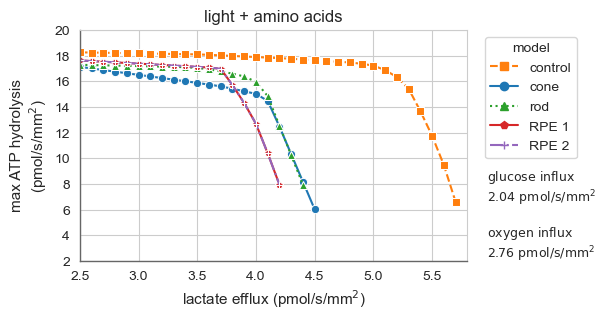

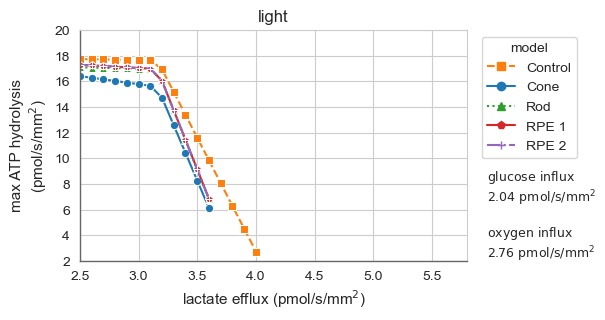

In [73]:
# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_light_no_aas_lactate_single.pkl')
df_light_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_dark_aas_lactate_single.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

##############################################################################
#####################         LACTATE LIGHT AAS       ########################
##############################################################################
import matplotlib.lines as mlines

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_aas_lactate_single, x=df_light_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(2,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_lactate_sweep_single_parafoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_lactate_sweep_single_parafoveal.xlsx')  

####################################################################################
########################         LACTATE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_no_aas_lactate_single, x=df_light_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

# x lim 0 to 30
ax.set_ylim(2,20)
ax.set_xlim(2.5,5.8)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_no_aas_lactate_sweep_single_parafoveal.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_lactate_sweep_single_parafoveal.xlsx')  

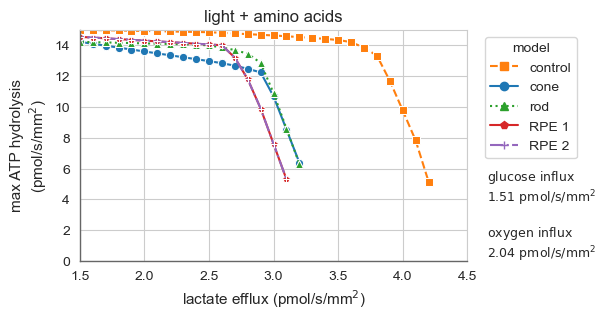

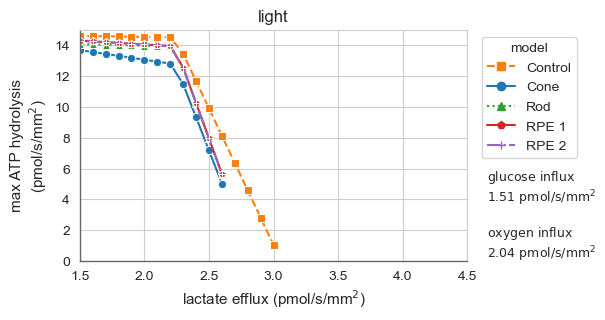

In [74]:
##############################################################################
#####################               FOVEAL            ########################
##############################################################################

# load pickes
pickle_folder = create_folder('results', 'paper','sweep', 'lactate', 'pickles')
df_light_no_aas_lactate_single_foveal = pd.read_pickle(pickle_folder +  '/df_light_no_aas_lactate_single_foveal.pkl')
df_light_aas_lactate_single_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_lactate_single_foveal.pkl')
df_dark_no_aas_lactate_single_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single_foveal.pkl')
df_dark_aas_lactate_single_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_lactate_single_foveal.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

##############################################################################
#####################         LACTATE LIGHT AAS       ########################
##############################################################################
import matplotlib.lines as mlines

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_aas_lactate_single_foveal, x=df_light_aas_lactate_single_foveal.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(0,15)
ax.set_xlim(1.5,4.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$1.51\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_lactate_sweep_single_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/light_aas_lactate_sweep_single_foveal.xlsx')  

####################################################################################
########################         LACTATE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_light_no_aas_lactate_single_foveal, x=df_light_no_aas_lactate_single_foveal.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(0,15)
ax.set_xlim(1.5,4.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_no_aas_lactate_sweep_single_foveal.png', bbox_inches='tight')
df_light_no_aas_foveal.to_excel(results_folder + '/light_no_aas_lactate_sweep_single_foveal.xlsx')  

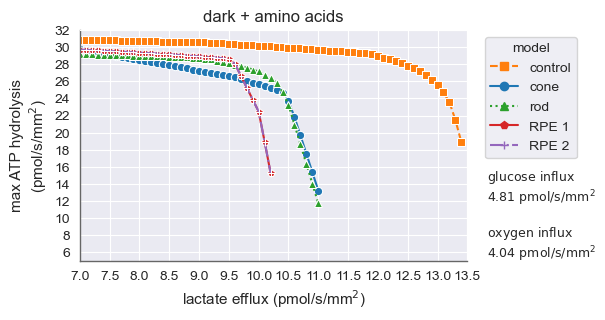

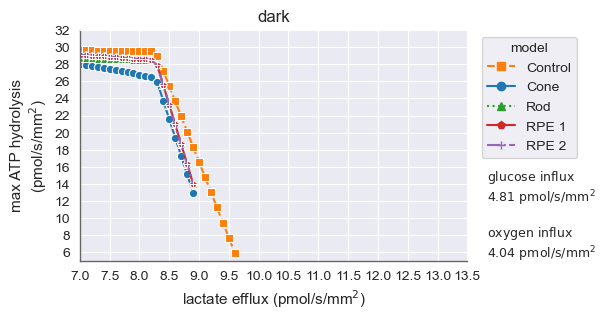

In [75]:
# load pickes
df_light_no_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_light_no_aas_lactate_single.pkl')
df_light_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_light_aas_lactate_single.pkl')
df_dark_no_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_lactate_single.pkl')
df_dark_aas_lactate_single = pd.read_pickle(pickle_folder +  '/df_dark_aas_lactate_single.pkl')

results_folder = create_folder('results', 'paper','sweep', 'lactate')

##############################################################################
#####################         LACTATE DARK AAS       ########################
##############################################################################

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_dark_aas_lactate_single, x=df_dark_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(5,32)
ax.set_xlim(7,13.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$4.81\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_lactate_sweep_single_parafoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/dark_aas_lactate_sweep_single_parafoveal.xlsx')  

####################################################################################
########################         LACTATE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df_dark_no_aas_lactate_single, x=df_dark_no_aas_lactate_single.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(5,32)
ax.set_xlim(7,13.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_single_parafoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/dark_no_aas_lactate_sweep_single_parafoveal.xlsx')  

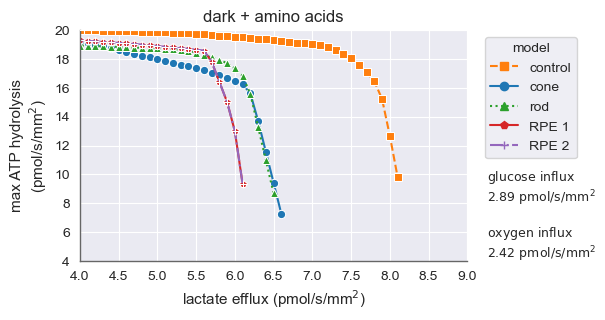

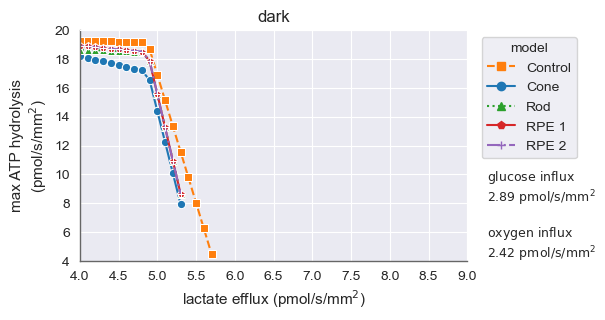

In [76]:

##############################################################################
#####################         FOVEAL  DARK        ########################
##############################################################################

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_aas_lactate_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(4,20)
ax.set_xlim(4,9)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))


# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{glucose\ influx}$',
    r'$2.89\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.42\ \mathrm{pmol/s/mm}^2$'))


# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_lactate_sweep_single_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/dark_aas_lactate_sweep_single_foveal.xlsx')  

####################################################################################
########################         LACTATE DARK NO AAS       ########################
####################################################################################
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_no_aas_lactate_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('lactate efflux (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(4,20)
ax.set_xlim(4,9)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_lactate_sweep_single_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/dark_no_aas_lactate_sweep_single_foveal.xlsx')  

In [77]:
# # uncomment to run again (takes ~ 10 min)

# ####################################################################################################
# ###########                                GLUCOSE SWEEPS                              #############
# ###########                                 LIGHT / DARK                               #############
# ###########                         WITH / WITHOUT AMINO ACIDS                         #############
# ####################################################################################################


# multiplication_factors_light = my_range(1,3,0.1)
# multiplication_factors_dark = my_range(2,5.5,0.1)


# # light
# results_dict_light_no_aas = {}
# results_dict_light_aas = {}
# # dark
# results_dict_dark_no_aas = {}
# results_dict_dark_aas = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -2.04, '')
            
#             ex_bounds_light =    {'MAR09048':(-2.76,-2.76),\
#                                   'MAR09034':(-i,-i),\
#                                   'MAR09135':(4.2,4.2)}

#             m = set_rxn_bounds(m,ex_bounds_light)

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.04, '')
#             m = set_rxn_bounds(m,ex_bounds_light)
            
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas[m.id] = objective_values_light_no_aas
#         results_dict_light_aas[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -4.81, '')   

#             ex_bounds_dark =  {'MAR09048':(-4.04,-4.04),\
#                                   'MAR09034':(-i,-i),\
#                                   'MAR09135':(8.34,8.34)}
            
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -4.81, '')   
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas[m.id] = objective_values_dark_aas

# df_light_no_aas_glucose_single = pd.DataFrame(results_dict_light_no_aas,index=multiplication_factors_light)
# df_light_aas_glucose_single = pd.DataFrame(results_dict_light_aas,index= multiplication_factors_light)
# df_dark_no_aas_glucose_single = pd.DataFrame(results_dict_dark_no_aas,index=multiplication_factors_dark)
# df_dark_aas_glucose_single = pd.DataFrame(results_dict_dark_aas,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder

# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# df_light_no_aas_glucose_single.to_pickle(pickle_folder + '/df_light_no_aas_glucose_single.pkl')
# df_light_aas_glucose_single.to_pickle(pickle_folder +  '/df_light_aas_glucose_single.pkl')
# df_dark_no_aas_glucose_single.to_pickle(pickle_folder + '/df_dark_no_aas_glucose_single.pkl')
# df_dark_aas_glucose_single.to_pickle(pickle_folder +  '/df_dark_aas_glucose_single.pkl')

In [78]:
# # # # uncomment to run again (takes ~ 10 min)

# # # ####################################################################################################
# # # ###########                                GLUCOSE SWEEPS                              #############
# # # ###########                                 FOVEAL                                     #############
# # # ####################################################################################################

# # FOVEAL
# single_ex_bounds_dark_foveal = {'MAR09048':(-2.42,-2.42),\
#                       'MAR09034':(-2.89,-2.89),\
#                         'MAR09135':(5.00,5.00)}

# single_ex_bounds_light_foveal = {'MAR09048':(-2.34,-2.34),\
#                        'MAR09034':(-1.51,-1.51),\
#                         'MAR09135':(3.11,3.11)}

# # single_ex_bounds_light_foveal = {'MAR09048':(-2.34,-2.34),\
# #                        'MAR09034':(-1.51,-1.51),\
# #                         'MAR09135':(3.11,3.11)}

# # single_ex_bounds_dark_foveal = {'MAR09048':(-2.42,-2.42),\
# #                       'MAR09034':(-2.89,-2.89),\
# #                         'MAR09135':(5.00,5.00)}

# multiplication_factors_light = my_range(0,8,0.1)
# multiplication_factors_dark = my_range(0,10,0.1)


# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.51, '')
            
#             ex_bounds_light =    {'MAR09048':(-2.34,-2.34),\
#                                 'MAR09034':(-i,-i),\
#                                 'MAR09135':(3.11,3.11)}

#             m = set_rxn_bounds(m,ex_bounds_light)

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.51, '')
#             m = set_rxn_bounds(m,ex_bounds_light)
            
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -2.89, '')   

#             ex_bounds_dark = {'MAR09048':(-2.42,-2.42),\
#                       'MAR09034':(-i,-i),\
#                         'MAR09135':(5.00,5.00)}
            
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.89, '')   
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_glucose_single_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_glucose_single_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_glucose_single_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_glucose_single_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder

# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# df_light_no_aas_glucose_single_foveal.to_pickle(pickle_folder + '/df_light_no_aas_glucose_single_foveal.pkl')
# df_light_aas_glucose_single_foveal.to_pickle(pickle_folder +  '/df_light_aas_glucose_single_foveal.pkl')
# df_dark_no_aas_glucose_single_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_glucose_single_foveal.pkl')
# df_dark_aas_glucose_single_foveal.to_pickle(pickle_folder +  '/df_dark_aas_glucose_single_foveal.pkl')

In [79]:
# # # # uncomment to run again (takes ~ 10 min)

# # # ####################################################################################################
# # # ###########                                GLUCOSE SWEEPS                              #############
# # # ###########                                 FOVEAL                                     #############
# # # ####################################################################################################


# # FOVEAL
# ex_bounds_dark_foveal_single = {'MAR09048':(-2.72,-2.72),\
#                       'MAR09034':(-2.89,-2.89),\
#                       'MAR09135':(5,5)}          

# ex_bounds_light_foveal_single = {'MAR09048':(-2.34,-2.34),\
#                       'MAR09034':(-1.51,-1.51),\
#                       'MAR09135':(3.11,3.11)}
	

# multiplication_factors_light = my_range(0,8,0.1)
# multiplication_factors_dark = my_range(0,10,0.1)


# # light
# results_dict_light_no_aas_foveal = {}
# results_dict_light_aas_foveal = {}
# # dark
# results_dict_dark_no_aas_foveal = {}
# results_dict_dark_aas_foveal = {}

# for model in single_models + Human1_models:
#     objective_values_light_aas = []
#     objective_values_light_no_aas = []
#     objective_values_dark_aas = []
#     objective_values_dark_no_aas = []

#     with model as m:

#         # ################ LIGHT ################

#         for i in multiplication_factors_light:
            
#             m = open_blood_exchange(m,blood_ratio0, -1.51, '')
            
#             ex_bounds_light =    {'MAR09048':(-2.34,-2.34),\
#                                 'MAR09034':(-i,-i),\
#                                 'MAR09135':(3.11,3.11)}

#             m = set_rxn_bounds(m,ex_bounds_light)

#             m.optimize()
#             objective_values_light_no_aas = objective_values_light_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -1.51, '')
#             m = set_rxn_bounds(m,ex_bounds_light)
            
#             m.optimize()
#             objective_values_light_aas = objective_values_light_aas  + [m.objective.value]

#         results_dict_light_no_aas_foveal[m.id] = objective_values_light_no_aas
#         results_dict_light_aas_foveal[m.id] = objective_values_light_aas

#         ################ DARK ################

#         for i in multiplication_factors_dark:

#             m = open_blood_exchange(m,blood_ratio0, -2.89, '')   

#             ex_bounds_dark = {'MAR09048':(-2.72,-2.72),\
#                       'MAR09034':(-i,-i),\
#                         'MAR09135':(5.00,5.00)}
            
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_no_aas = objective_values_dark_no_aas  + [m.objective.value]

#             m = open_blood_exchange(m,blood_ratio, -2.89, '')   
#             m = set_rxn_bounds(m,ex_bounds_dark)

#             m.optimize()
#             objective_values_dark_aas = objective_values_dark_aas  + [m.objective.value]

#         results_dict_dark_no_aas_foveal[m.id] = objective_values_dark_no_aas
#         results_dict_dark_aas_foveal[m.id] = objective_values_dark_aas

# df_light_no_aas_glucose_single_foveal = pd.DataFrame(results_dict_light_no_aas_foveal,index=multiplication_factors_light)
# df_light_aas_glucose_single_foveal = pd.DataFrame(results_dict_light_aas_foveal,index= multiplication_factors_light)
# df_dark_no_aas_glucose_single_foveal = pd.DataFrame(results_dict_dark_no_aas_foveal,index=multiplication_factors_dark)
# df_dark_aas_glucose_single_foveal = pd.DataFrame(results_dict_dark_aas_foveal,index= multiplication_factors_dark)

# # create results / lactate sweep folder in user folder

# pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')

# # pickle df_light_no_aas, df_light_aas, df_dark_no_aas, df_dark_aas
# df_light_no_aas_glucose_single_foveal.to_pickle(pickle_folder + '/df_light_no_aas_glucose_single_foveal.pkl')
# df_light_aas_glucose_single_foveal.to_pickle(pickle_folder +  '/df_light_aas_glucose_single_foveal.pkl')
# df_dark_no_aas_glucose_single_foveal.to_pickle(pickle_folder + '/df_dark_no_aas_glucose_single_foveal.pkl')
# df_dark_aas_glucose_single_foveal.to_pickle(pickle_folder +  '/df_dark_aas_glucose_single_foveal.pkl')

c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\prins\miniconda3\envs\RPE-PR_pytest2\lib\site-packages\c

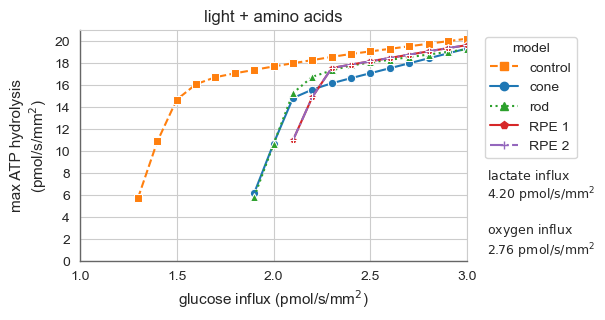

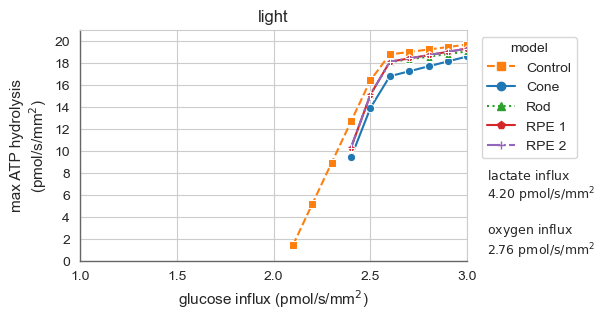

In [80]:
# load glucose pickles
pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose_single = pd.read_pickle(pickle_folder + '/df_light_no_aas_glucose_single.pkl')
df_light_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose_single.pkl')
df_dark_no_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_single.pkl')
df_dark_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_single.pkl')

results_folder = create_folder('results', 'paper','sweep', 'glucose')


##############################################################################
#####################         GLUCOSE LIGHT AAS       ########################
##############################################################################

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_light_aas_glucose_single

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(0,21)
ax.set_xlim(1,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx}$',
    r'$4.20\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.76\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_glucose_sweep_single_parafoveal.png', bbox_inches='tight')
df_light_aas.to_excel(results_folder + '/light_aas_glucose_sweep_single_parafoveal.xlsx')  

####################################################################################
########################         GLUCOSE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_light_no_aas_glucose_single

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(0,21)
ax.set_xlim(1,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_no_aas_glucose_sweep_single_parafoveal.png', bbox_inches='tight')
df_light_no_aas.to_excel(results_folder + '/light_no_aas_glucose_sweep_single_parafoveal.xlsx')  

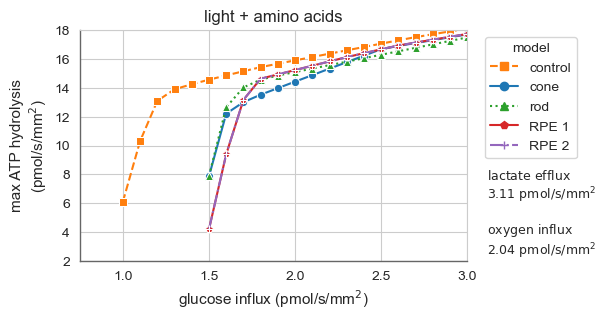

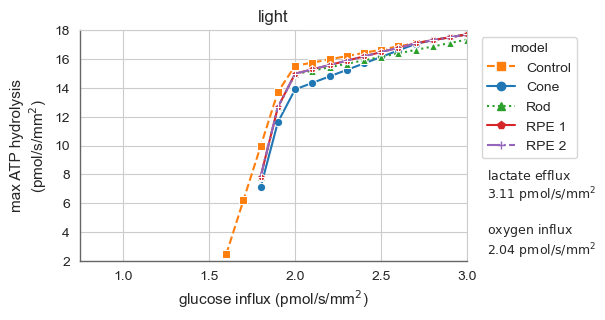

In [81]:
##############################################################################
#####################               FOVEAL            ########################
##############################################################################


# load glucose pickles
pickle_folder = create_folder('results', 'paper','sweep', 'glucose', 'pickles')
df_light_no_aas_glucose_single_foveal = pd.read_pickle(pickle_folder + '/df_light_no_aas_glucose_single_foveal.pkl')
df_light_aas_glucose_single_foveal = pd.read_pickle(pickle_folder +  '/df_light_aas_glucose_single_foveal.pkl')
df_dark_no_aas_glucose_single_foveal = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_single_foveal.pkl')
df_dark_aas_glucose_single_foveal = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_single_foveal.pkl')

results_folder = create_folder('results', 'paper','sweep', 'glucose')


##############################################################################
#####################         GLUCOSE LIGHT AAS       ########################
##############################################################################

sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_light_aas_glucose_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(2,18)
ax.set_xlim(.75,3)


# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$3.11\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.04\ \mathrm{pmol/s/mm}^2$')) 


# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_aas_glucose_sweep_single_foveal.png', bbox_inches='tight')
df_light_aas_foveal.to_excel(results_folder + '/light_aas_glucose_sweep_single_foveal.xlsx')  

####################################################################################
########################         GLUCOSE LIGHT NO AAS       ########################
####################################################################################
sns.set_style("whitegrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_light_no_aas_glucose_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('light')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(2,18)
ax.set_xlim(.75,3)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/light_no_aas_glucose_sweep_single_foveal.png', bbox_inches='tight')
df_light_no_aas_foveal.to_excel(results_folder + '/light_no_aas_glucose_sweep_single_foveal.xlsx')  

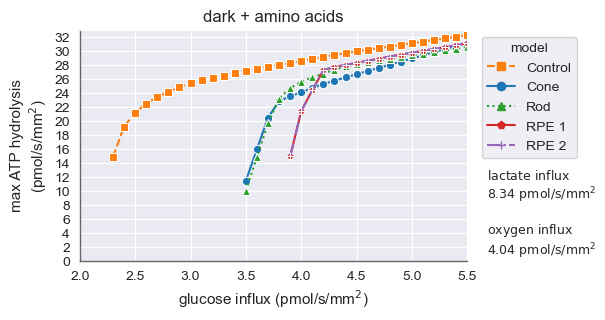

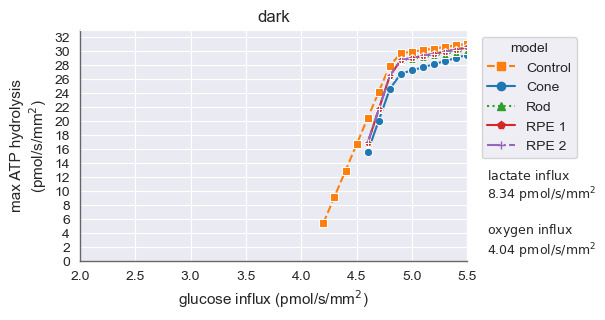

In [82]:
# load glucose pickles
df_dark_no_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_dark_no_aas_glucose_single.pkl')
df_dark_aas_glucose_single = pd.read_pickle(pickle_folder +  '/df_dark_aas_glucose_single.pkl')

results_folder = create_folder('results', 'paper','sweep', 'glucose')

##############################################################################
#####################         GLUCOSE DARK AAS       ########################
##############################################################################

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_aas_glucose_single

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(0,33)
ax.set_xlim(2,5.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ influx}$',
    r'$8.34\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$4.04\ \mathrm{pmol/s/mm}^2$')) 

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_glucose_sweep_single_parafoveal.png', bbox_inches='tight')
df_dark_aas.to_excel(results_folder + '/dark_aas_glucose_sweep_single_parafoveal.xlsx')  

####################################################################################
########################         GLUCOSE DARK NO AAS       ########################
####################################################################################
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_no_aas_glucose_single

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(0,33)
ax.set_xlim(2,5.5)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep_single_parafoveal.png', bbox_inches='tight')
df_dark_no_aas.to_excel(results_folder + '/dark_no_aas_glucose_sweep_single_parafoveal.xlsx')  

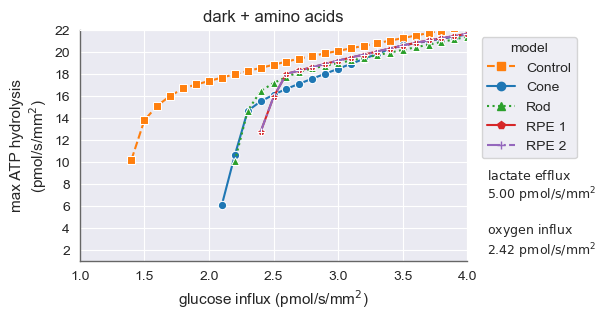

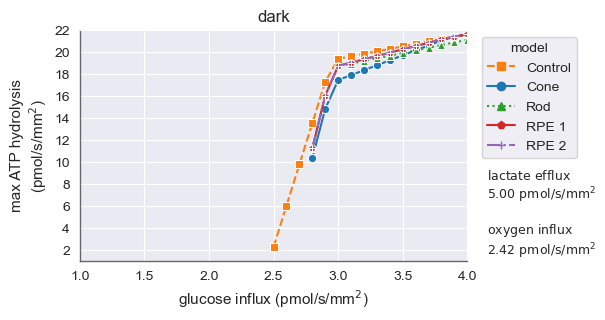

In [83]:
##############################################################################
#####################               FOVEAL            ########################
##############################################################################

results_folder = create_folder('results', 'paper','sweep', 'glucose')

##############################################################################
#####################         GLUCOSE DARK AAS       ########################
##############################################################################

sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_aas_glucose_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')
plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark + amino acids')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(1,22)
ax.set_xlim(1,4)


# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with info
textstr = '\n'.join((
    r'$\mathrm{lactate\ efflux}$',
    r'$5.00\ \mathrm{pmol/s/mm}^2$',
    r'',
    r'$\mathrm{oxygen\ influx}$',
    r'$2.42\ \mathrm{pmol/s/mm}^2$')) 


# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_aas_glucose_sweep_single_foveal.png', bbox_inches='tight')
df_dark_aas_foveal.to_excel(results_folder + '/dark_aas_glucose_sweep_single_foveal.xlsx')  

####################################################################################
########################         GLUCOSE DARK NO AAS       ########################
####################################################################################
sns.set_style("darkgrid", {'axes.grid' : True})
fig, ax = plt.subplots(figsize=(5,3))

df = df_dark_no_aas_glucose_single_foveal

sns.lineplot(data=df, x=df.index, y='Human-GEM_28062023', color=orange, marker='s', linestyle='--') # control
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singlePR', color=blue, marker='o', linestyle='-') # cone
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singlePR', color=green, marker='^', linestyle=':') # rod
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRcone_Lukowski_singleRPE', color=red, marker='p', linestyle='-') # RPE
sns.lineplot(data=df, x=df.index, y='mod_RPE_PRrod_Lukowski_singleRPE', color=purple, marker='+', linestyle='-.') # RPE

# create custom legend entries
control_line = mlines.Line2D([], [], color=orange, marker='s', linestyle='--', label='Control')
cone_line = mlines.Line2D([], [], color=blue, marker='o', linestyle='-', label='Cone')
rod_line = mlines.Line2D([], [], color=green, marker='^', linestyle=':', label='Rod')
rpe_cone_line = mlines.Line2D([], [], color=red, marker='p', linestyle='-', label='RPE 1')
rpe_rod_line = mlines.Line2D([], [], color=purple, marker='+', linestyle='-.', label='RPE 2')

# add legend
plt.legend(handles=[control_line, cone_line, rod_line, rpe_cone_line, rpe_rod_line], loc='upper right',bbox_to_anchor=(1.3, 1.0), title='model')

plt.xlabel('glucose influx (pmol/s/mm$^2$)',fontsize=11)
plt.ylabel('max ATP hydrolysis\n(pmol/s/mm$^2$)',fontsize=11)
plt.title('dark')

# change spine color to dg
ax.spines['bottom'].set_color(dg)
ax.spines['left'].set_color(dg)
#set spine linewidth to 1
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

ax.set_ylim(1,22)
ax.set_xlim(1,4)

# grid lines at whole numbers only
ax.xaxis.set_major_locator(MultipleLocator(.5))
ax.yaxis.set_major_locator(MultipleLocator(2))

# add textbox with textstr below legend with anchor to textbox
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(1.05, .4, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props)

fig.savefig(results_folder + '/dark_no_aas_glucose_sweep_single_foveal.png', bbox_inches='tight')
df_dark_no_aas_foveal.to_excel(results_folder + '/dark_no_aas_glucose_sweep_single_foveal.xlsx')  

In [84]:
# function to find minimum index of df
def find_min(df):
    return df.idxmin()

df = df_light_no_aas_glucose_single
glucose_light_no_aas_min = df.min()
glucose_light_no_aas_min_idx = df.idxmin()
glucose_light_no_aas_min_idx

mod_RPE_PRcone_Lukowski_singlePR     2.4
mod_RPE_PRcone_Lukowski_singleRPE    2.4
mod_RPE_PRrod_Lukowski_singlePR      2.4
mod_RPE_PRrod_Lukowski_singleRPE     2.4
Human-GEM_28062023                   2.1
dtype: float64

In [85]:
# find min glucose boundaries for sweeps 

def make_df_min(s,c,name_string):
    s = pd.DataFrame(s.idxmin())
    c = pd.DataFrame(c.idxmin())
    sc = pd.concat([s,c], axis=0)
    sc.columns = [name_string]
    return sc

# GLUCOSE MINS (LIGHT/DARK, AAS/NO AAS)
sc1 = make_df_min(df_light_no_aas_glucose_single,df_light_no_aas_glucose,'light_no_aas__glucose_min')
sc2 = make_df_min(df_light_aas_glucose_single,df_light_aas_glucose,'light_aas__glucose_min')
sc3 = make_df_min(df_dark_no_aas_glucose_single,df_dark_no_aas_glucose,'dark_no_aas__glucose_min')
sc4 = make_df_min(df_dark_aas_glucose_single,df_dark_aas_glucose,'dark_aas__glucose_min')
# LACTATE MINS (LIGHT/DARK, AAS/NO AAS)
sc5 = make_df_min(df_light_no_aas_lactate_single,df_light_no_aas,'light_no_aas__lactate_min')
sc6 = make_df_min(df_light_aas_lactate_single,df_light_aas,'light_aas__lactate_min')
sc7 = make_df_min(df_dark_no_aas_lactate_single,df_dark_no_aas,'dark_no_aas__lactate_min')
sc8 = make_df_min(df_dark_aas_lactate_single,df_dark_aas,'dark_aas__lactate_min')

# do same for foveal
sc9 = make_df_min(df_light_no_aas_glucose_single_foveal,df_light_no_aas_glucose_foveal,'light_no_aas_foveal__glucose_min')
sc10 = make_df_min(df_light_aas_glucose_single_foveal,df_light_aas_glucose_foveal,'light_aas_foveal__glucose_min')
sc11 = make_df_min(df_dark_no_aas_glucose_single_foveal,df_dark_no_aas_glucose_foveal,'dark_no_aas_foveal__glucose_min')
sc12 = make_df_min(df_dark_aas_glucose_single_foveal,df_dark_aas_glucose_foveal,'dark_aas_foveal__glucose_min')
# LACTATE MINS (LIGHT/DARK, AAS/NO AAS)
sc13 = make_df_min(df_light_no_aas_lactate_single_foveal,df_light_no_aas_glucose_foveal,'light_no_aas_foveal__lactate_min')
sc14 = make_df_min(df_light_aas_lactate_single_foveal,df_light_aas_glucose_foveal,'light_aas_foveal__lactate_min')
sc15 = make_df_min(df_dark_no_aas_lactate_single_foveal,df_dark_no_aas_glucose_foveal,'dark_no_aas_foveal__lactate_min')
sc16 = make_df_min(df_dark_aas_lactate_single_foveal,df_dark_aas_glucose_foveal,'dark_aas_foveal__lactate_min')

# concatenate all min dfs
sc = pd.concat([sc1, sc9, sc2, sc10, sc3, sc11, sc4, sc12, sc5, sc13, sc6, sc14, sc7, sc15, sc8, sc16], axis=1)

# write sc as excel into results folder
results_folder = create_folder('results', 'paper','sweep')
sc.to_excel(results_folder + '/min_lactate_glucose.xlsx')

sc

,light_no_aas__glucose_min,light_no_aas_foveal__glucose_min,light_aas__glucose_min,light_aas_foveal__glucose_min,dark_no_aas__glucose_min,dark_no_aas_foveal__glucose_min,dark_aas__glucose_min,dark_aas_foveal__glucose_min,light_no_aas__lactate_min,light_no_aas_foveal__lactate_min,light_aas__lactate_min,light_aas_foveal__lactate_min,dark_no_aas__lactate_min,dark_no_aas_foveal__lactate_min,dark_aas__lactate_min,dark_aas_foveal__lactate_min
mod_RPE_PRcone_Lukowski_singlePR,2.4,1.8,1.9,1.5,4.6,2.8,3.5,2.1,3.6,2.6,4.5,3.2,8.9,5.3,11.0,6.6
mod_RPE_PRcone_Lukowski_singleRPE,2.4,1.8,2.1,1.5,4.6,2.8,3.9,2.4,3.6,2.6,4.2,3.1,8.9,5.3,10.2,6.1
mod_RPE_PRrod_Lukowski_singlePR,2.4,1.8,1.9,1.5,4.6,2.8,3.5,2.2,3.6,2.6,4.4,3.2,8.9,5.3,11.0,6.5
mod_RPE_PRrod_Lukowski_singleRPE,2.4,1.8,2.1,1.5,4.6,2.8,3.9,2.4,3.6,2.6,4.2,3.1,8.9,5.3,10.2,6.1
Human-GEM_28062023,2.1,1.6,1.3,1.0,4.2,2.5,2.3,1.4,4.0,3.0,5.7,4.2,9.6,5.7,13.4,8.1
mod_RPE_PRcone_Lukowski,2.4,2.2,1.7,1.7,4.6,3.9,3.1,3.0,3.6,2.2,4.9,1.7,8.9,3.9,11.9,3.0
mod_RPE_PRcontrol,2.1,1.9,1.3,1.3,4.2,3.5,2.3,2.4,4.0,1.9,5.7,1.3,9.6,3.5,13.4,2.4
mod_RPE_PRrod_Lukowski,2.4,2.2,1.7,1.7,4.6,3.9,3.1,3.0,3.6,2.2,4.9,1.7,8.9,3.9,11.9,3.0


In [86]:
# write function to create models that only contain specific subsystem reactions
def create_subsystem_model(m, subsystem):
    m_subsystem = cobra.Model()
    m_subsystem.add_reactions([r for r in m.reactions if r.subsystem == subsystem])
    # create subsystem_str with underscores instead of spaces and no slashes
    subsystem_str = subsystem.replace(' ', '_').replace('/', '')


    m_subsystem.name = m.name + '_' + subsystem_str
    m_subsystem.id = m.id +'_' + subsystem_str
    return m_subsystem

# make new model with only selected reactions 'glycolysis_rxns' 
m_glycolysis = create_subsystem_model(model_list[1], 'Glycolysis / Gluconeogenesis')
m_glycolysis

Name,mod_RPE_PRcone_Lukowski_Glycolysis__Gluconeogenesis
Memory address,20198efb9a0
Number of metabolites,98
Number of reactions,46
Number of genes,60
Number of groups,0
Objective expression,0
Compartments,"c_RPE, x_RPE, m_RPE, c_PR, x_PR, m_PR"


In [87]:
# create results_folder
from cobra.io import  write_sbml_model, save_json_model

results_folder = create_folder('results', 'subset_models','Glycolysis_Gluconeogenesis')
for m in model_list:
    m_subsystem = create_subsystem_model(m, 'Glycolysis / Gluconeogenesis')
    r_objective = [r.id for r in m_subsystem.reactions if 'MAR04358' in r.id]
    for r in r_objective:
        if '_PR' in r:
            m_subsystem.objective = r
        else:
            m_subsystem.objective = r_objective[0]
    m_subsystem.optimize()  
    print(m_subsystem.objective.value)
    # save m_subsystem in results_folder with name m_subsystem.id + glycolysis as sbmbl model
    write_sbml_model(m_subsystem, results_folder + '/' + str(m_subsystem.id) + '_glycolysis.xml')
    save_json_model(m_subsystem, results_folder + '/' + str(m_subsystem.id) + '_glycolysis.json')
    print(str(m_subsystem.id))

0.0
Human-GEM_28062023_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRcone_Lukowski_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRcone_Lukowski_singlePR_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRcone_Lukowski_singleRPE_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRcontrol_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRrod_Lukowski_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRrod_Lukowski_singlePR_Glycolysis__Gluconeogenesis
0.0
mod_RPE_PRrod_Lukowski_singleRPE_Glycolysis__Gluconeogenesis


In [88]:
m_subsystem = create_subsystem_model(model_list[0], 'Glycolysis / Gluconeogenesis')

from src.get_info import add_compartment2rxn
# list reactions in m_subsystem
pd.DataFrame([[r.id,r.name,add_compartment2rxn(r)] for r in m_subsystem.reactions])

,0,1,2
0,MAR03905,ethanol:NAD+ oxidoreductase,ethanol[c] + NAD+[c] --> acetaldehyde[c] + H+[...
1,MAR03907,Ethanol:NADP+ oxidoreductase,ethanol[c] + NADP+[c] --> acetaldehyde[c] + H+...
2,MAR04097,Acetate:CoA ligase (AMP-forming),acetate[c] + ATP[c] + CoA[c] --> acetyl-CoA[c]...
3,MAR04099,Acetate:CoA ligase (AMP-forming),acetate[m] + ATP[m] + CoA[m] --> acetyl-CoA[m]...
4,MAR04108,acetyl adenylate:CoA acetyltransferase,acetyl adenylate[c] + CoA[c] --> acetyl-CoA[c]...
5,MAR04133,ATP:acetate adenylyltransferase,acetate[c] + ATP[c] + H+[c] --> acetyl adenyla...
6,MAR04281,(S)-Lactate:NAD+ oxidoreductase,H+[x] + NADH[x] + pyruvate[x] <=> L-lactate[x]...
7,MAR04388,(S)-Lactate:NAD+ oxidoreductase,H+[c] + NADH[c] + pyruvate[c] <=> L-lactate[c]...
8,MAR04283,Acetaldehyde:NADP+ oxidoreductase,acetaldehyde[c] + H2O[c] + NADP+[c] --> acetat...
9,MAR08357,Acetaldehyde:NAD+ oxidoreductase,acetaldehyde[m] + H2O[m] + NAD+[m] --> acetate...


In [89]:
br
# list of keys in br
br_keys = list(br.keys())


In [90]:
#####################################################################################################################################
########################################  ATP YIELD PER METABOLITE, DIFFERENT OXYGEN LEVELS  ########################################
#####################################################################################################################################

In [91]:
# set exchange bounds for blood to new estimates (14-08-2023; based on Linsenmeier et al. 1993)

# MAR09048: oxygen 
# MAR09034: glucose 
# MAR09135: lactate 

##############################################################
#######    total exchange (for single models)        #########
##############################################################

ox_bounds_dark_single = {'MAR09048':(-4.04,-4.04)}
ox_bounds_light_single = {'MAR09048':(-2.76,-2.76)}

##############################################################
##############     CC exchange  (CC --> RPE)  ################
####  inner retina exchange  (retina vasculature --> PR)  ####
##############################################################

ox_bounds_dark = {'MAR09048_RPE':(-3.48,-3.48),\
                      'MAR09048_PR':(-0.56,-0.56)}          

ox_bounds_light = {'MAR09048_RPE':(-2.49,-2.49),\
                      'MAR09048_PR':(-0.27,-0.27)}

In [92]:
def get_by_id_RPE_PR(m, id):
    reactions_list = [r.id for r in m.reactions]
    if (id + '_RPE') in reactions_list:
        return m.reactions.get_by_id(id + '_RPE')
    elif (id + '_PR') in reactions_list:
        return m.reactions.get_by_id(id + '_PR')
    elif (id) in reactions_list:
        return m.reactions.get_by_id(id)
    else:
        print('exchange reaction not found')
        
get_by_id_RPE_PR(model_list[0], 'MAR09048')

Reaction identifier,MAR09048
Name,
Memory address,0x200b8f257b0
Stoichiometry,MAM02630e --> O2 -->
GPR,
Lower bound,0
Upper bound,1000


In [93]:
oxygen_levels  = [(-1000,0),(-4.04,0),(-2.76,0),(0,0)]
results_dict_single = {}

for model in single_models + Human1_models:
    with model as m:
        reactions_list = [r.id for r in m.reactions]
        for o in oxygen_levels:
            get_by_id_RPE_PR(m, 'MAR09048').bounds = o    
            for k in br_keys:
                get_by_id_RPE_PR(m, k).bounds = (-1,0)
                m.optimize()
                str_i = str(o) + str(m.id) + str(k)
                results_dict_single[str_i] = m.objective.value
                get_by_id_RPE_PR(m, k).bounds = (0,0)    
results_dict_single

{'(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09034': 26.000000000000007,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09063': 14.625000000000004,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09061': 11.500000000000004,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09067': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09041': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09046': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09068': 18.5,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09044': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09069': 9.25,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09040': 0.0,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09038': 2.25,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09066': 19.625,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09064': 2.5,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09043': 2.5,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR09065': 11.75,
 '(-1000, 0)mod_RPE_PRcone_Lukowski_singlePRMAR

In [94]:
# MINIMISE OXYGEN UPTAKE WITH FIXED ATP HYDROLYSIS RATES 

ATP_day_rods = 11.41
ATP_day_cones = 30.72
ATP_day_RPE = 2.01

ATP_night_rods = 26.57
ATP_night_cones = 44.34
ATP_night_RPE = 0.79



